In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from scipy.special import expit
from sklearn.metrics import roc_auc_score
import random
import tqdm
import optuna

In [2]:
import sys
import importlib
sys.path.append('/home/ec2-user/SageMaker/Bias/')
import fairness
# importlib.reload(fairness.xgb_classifier)

In [3]:
# from fairness.data_simulation import DataGenerator
from fairness.split_data import perform_train_test_split
# from fairness.models import Encoder, Predictor, Adversary
from fairness.init_networks import initialize_networks
from fairness.data_loaders import create_dataloaders
from fairness.training_components import initialize_training_components
# from fairness.train import train_model
from fairness.plots import plot_lines,plot_comparison_heatmaps, plot_auc_roc_curve
from fairness.test import get_transformed_features, get_predictions
from fairness.eval import evaluate_classifier
from fairness.fairness_metrics import get_demographic_parity
from fairness.MI import calculate_MI
from fairness.xgb_classifier import train_xgb_classifier
from fairness.xgb_optuna import objective

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [4]:
def joint_entropies(data, nbins=None):
    n_variables = data.shape[-1]
    n_samples = data.shape[0]
    if nbins == None:
        nbins = int((n_samples/5)**.5)
    histograms2d = np.zeros((n_variables, n_variables, nbins, nbins))
    for i in range(n_variables):
        for j in range(n_variables):
            histograms2d[i,j] = np.histogram2d(data[:,i], data[:,j], bins=nbins)[0]
    probs = histograms2d / len(data) + 1e-100
    joint_entropies = -(probs * np.log2(probs)).sum((2,3))
    return joint_entropies

def mutual_info_matrix(df, nbins=None, normalized=True):
    data = df.to_numpy()
    n_variables = data.shape[-1]
    j_entropies = joint_entropies(data, nbins)
    entropies = j_entropies.diagonal()
    entropies_tile = np.tile(entropies, (n_variables, 1))
    sum_entropies = entropies_tile + entropies_tile.T
    mi_matrix = sum_entropies - j_entropies
    if normalized:
        mi_matrix = mi_matrix * 2 / sum_entropies    
    return pd.DataFrame(mi_matrix, index=df.columns, columns=df.columns)

In [5]:
def generate_simulated_data(n, d, num_non_sensitive, num_sensitive, subset_size, num, binary, seed):
    data = []

    if seed:
        np.random.seed(seed)
        random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)  # If using GPU

    thresholds = np.round(np.random.uniform(0.1, 0.9, num_sensitive), 2)
#     coefficients = np.array([0.5, -0.3, 1.2, 0.7, -0.8])
    coefficients = np.random.randn(d)

    subsets = []
    for _ in range(d):
        subset = np.random.choice(num, subset_size, replace=False)
        subsets.append(subset)

    quadratic_functions = []
    for subset in subsets:
        a = np.random.randn(len(subset))  # coefficients for squares
        cross_terms = np.random.randn(len(subset) * (len(subset) - 1) // 2)  # cross terms coefficients
        quadratic_functions.append((a, cross_terms, subset))

    subsets_y = []
    for _ in range(d):
        subset = np.random.choice(num, subset_size, replace=False)
        subsets_y.append(subset)

    quadratic_functions_y = []
    for subset in subsets_y:
        a = np.random.randn(len(subset))  # coefficients for squares
        cross_terms = np.random.randn(len(subset) * (len(subset) - 1) // 2)  # cross terms coefficients
        quadratic_functions_y.append((a, cross_terms, subset))

    for _ in tqdm.tqdm(range(n)):
        X = np.random.normal(0, 1, num)
                        
        def evaluate_quadratic(X, a, cross_terms, subset):
            result = 0
            # quadratic terms: a_i * X_i^2
            for i, idx in enumerate(subset):
                result += a[i] * X[idx]**2
            
            # cross terms: a_ij * X_i * X_j for i < j
            idx = 0
            for i in range(len(subset)):
                for j in range(i + 1, len(subset)):
                    result += cross_terms[idx] * X[subset[i]] * X[subset[j]]
                    idx += 1
            
            return result
        
        function_values = []
        for (a, cross_terms, subset) in quadratic_functions:
            func_val = evaluate_quadratic(X, a, cross_terms, subset)
            function_values.append(func_val)
        
#         print(X)
#         break
        binary_vars = []
        for i in range(num_sensitive):
            threshold = thresholds[i]
            binary_value = 1 if function_values[num_non_sensitive + i] >= threshold else 0
            binary_vars.append(binary_value)

        function_values_y = []
        for (a, cross_terms, subset) in quadratic_functions_y:
            func_val = evaluate_quadratic(X, a, cross_terms, subset)
            function_values_y.append(func_val)

        linear_combination = np.dot(function_values_y, coefficients)
        probability = 1 / (1 + np.exp(-linear_combination))
        y = 1 if probability > 0.5 else 0


        row = function_values[:num_non_sensitive] + binary_vars + [y]
        data.append(row)
        
    column_names = [f"X{i+1}" for i in range(num_non_sensitive)] + [f"S{i+1}" for i in range(num_sensitive)] + ["Y"]
    df = pd.DataFrame(data, columns=column_names)
    return df

In [6]:
num_non_sensitive = 4
num_sensitive = 1
binary = num_sensitive + 1
d = num_non_sensitive + num_sensitive + 1
num = 4
subset_size = 2
n = 10000
seed = 69

data = generate_simulated_data(n, d, num_non_sensitive, num_sensitive, subset_size, num, binary, seed)
print(data.head())

100%|██████████| 10000/10000 [00:00<00:00, 16748.15it/s]


         X1        X2        X3        X4  S1  Y
0  0.132689  0.198091 -0.176781 -0.047388   0  1
1  2.884844 -0.491054 -0.010165 -1.776016   1  1
2  0.488059  1.031786 -0.101411 -0.078521   0  1
3  2.842068 -1.463188  0.261192 -0.494718   0  1
4  2.090066 -2.606464  0.023429 -0.170081   1  0


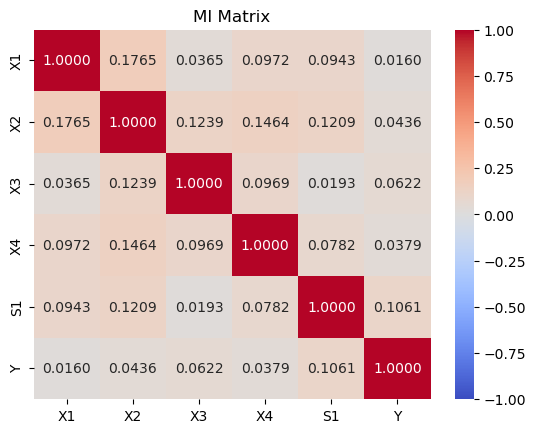

In [7]:
# plt.figure(figsize=(8,8))
sns.heatmap(mutual_info_matrix(data), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('MI Matrix')
plt.show()

In [8]:
num_sensitive = 1
num_non_sensitive = 4
data_train, data_val, data_test = perform_train_test_split(data, num_non_sensitive=num_non_sensitive, num_sensitive=num_sensitive, test_size=0.15, val_size=0.1,random_state=69)

print(data_train.shape, data_val.shape, data_test.shape)

(7499, 6) (1001, 6) (1500, 6)


In [9]:
X_train, Y_train = data_train[['X1', 'X2', 'X3', 'X4']], data_train[['Y']]
X_test, Y_test = data_test[['X1', 'X2', 'X3', 'X4']], data_test[['Y']]
model_before = train_xgb_classifier(X_train, Y_train, seed=42)

Y_pred = model_before.predict(X_test)
Y_test = np.array(Y_test).reshape(-1)
Y_probs = model_before.predict_proba(X_test)

print(roc_auc_score(Y_test,Y_probs[:, 1]))

0.8828794119620529


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [23:47:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [11]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train, X_test, Y_train, Y_test), n_trials=100)

[I 2024-12-10 23:48:33,281] A new study created in memory with name: no-name-bdb0b9f9-9a9a-4f82-adb3-b541ae3c4b82
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  '

Trial 0:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.17588765919165797, 'n_estimators': 430, 'subsample': 0.9439498931836987, 'colsample_bytree': 0.7047714025306925, 'gamma': 0.29095832438502467, 'min_child_weight': 7}
Accuracy: 0.808, Precision: 0.8437775816416593, Recall: 0.8959700093720713, F1-score: 0.8690909090909091, AUC: 0.8707206105482337
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 1:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.1082719091660565, 'n_estimators': 214, 'subsample': 0.8112057715349545, 'colsample_bytree': 0.9513102122209045, 'gamma': 0.1427787330411528, 'min_child_weight': 6}
Accuracy: 0.8073333333333333, Precision: 0.8542805100182149, Recall: 0.8791002811621368, F1-score: 0.8665127020785219, AUC: 0.8816716485105334
--------------------------------------------------
Trial 2:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.022806773303747505, 'n_estimators': 138, 'subsample': 0.881168541193195, 'colsample_bytree': 0.707619052521217, 'gamma': 0.47380701679182047, 'min_child_weight': 7}
Accuracy: 0.764, Precision: 0.779607843137255, Recall: 0.9315838800374883, F1-score: 0.8488471391972673, AUC: 0.8177262013242108
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 3:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.04431225665596527, 'n_estimators': 466, 'subsample': 0.7122030550495816, 'colsample_bytree': 0.7938340458103706, 'gamma': 0.4503209166469215, 'min_child_weight': 2}
Accuracy: 0.8093333333333333, Precision: 0.853393665158371, Recall: 0.8837863167760075, F1-score: 0.8683241252302025, AUC: 0.8824140550766109
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 4:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.0534346131921301, 'n_estimators': 158, 'subsample': 0.9156664129736717, 'colsample_bytree': 0.8900505540545998, 'gamma': 0.13922750815288326, 'min_child_weight': 6}
Accuracy: 0.7966666666666666, Precision: 0.8342105263157895, Recall: 0.8912839737582006, F1-score: 0.8618033529678296, AUC: 0.8654718177705726
--------------------------------------------------
Trial 5:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.01845227699392682, 'n_estimators': 243, 'subsample': 0.7311672895980651, 'colsample_bytree': 0.7918519323035336, 'gamma': 0.0025780861202581717, 'min_child_weight': 7}
Accuracy: 0.7746666666666666, Precision: 0.8014888337468983, Recall: 0.9081537019681349, F1-score: 0.851493848857645, AUC: 0.8447049962013891
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 6:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.1912097936516555, 'n_estimators': 454, 'subsample': 0.8516004226861316, 'colsample_bytree': 0.8866275885752911, 'gamma': 0.24784560659345495, 'min_child_weight': 8}
Accuracy: 0.81, Precision: 0.8528880866425993, Recall: 0.8856607310215557, F1-score: 0.8689655172413793, AUC: 0.8796976695360068
--------------------------------------------------
Trial 7:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.09756349142257764, 'n_estimators': 127, 'subsample': 0.9336480356113845, 'colsample_bytree': 0.9909876223938542, 'gamma': 0.24228192544328064, 'min_child_weight': 2}
Accuracy: 0.78, Precision: 0.8152266894781864, Recall: 0.8931583880037488, F1-score: 0.8524150268336315, AUC: 0.8523541647276796
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 8:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.09586719332423156, 'n_estimators': 279, 'subsample': 0.9387193459705336, 'colsample_bytree': 0.7577885460970348, 'gamma': 0.2872820515804892, 'min_child_weight': 8}
Accuracy: 0.8046666666666666, Precision: 0.8537477148080439, Recall: 0.8753514526710403, F1-score: 0.8644146228597871, AUC: 0.879923854626838
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 9:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.018150173394022504, 'n_estimators': 245, 'subsample': 0.8665578070804, 'colsample_bytree': 0.9598321481070848, 'gamma': 0.4912793338965593, 'min_child_weight': 6}
Accuracy: 0.7846666666666666, Precision: 0.8184931506849316, Recall: 0.8959700093720713, F1-score: 0.8554809843400447, AUC: 0.8543541171097657
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 10:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.04210457592059299, 'n_estimators': 370, 'subsample': 0.7032790471886882, 'colsample_bytree': 0.8093581968254497, 'gamma': 0.3911129108542455, 'min_child_weight': 1}
Accuracy: 0.8006666666666666, Precision: 0.8434704830053668, Recall: 0.8837863167760075, F1-score: 0.8631578947368421, AUC: 0.8809703665064252
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 11:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.09615838442977719, 'n_estimators': 355, 'subsample': 0.7842106919730494, 'colsample_bytree': 0.8587829110576342, 'gamma': 0.11335720491090284, 'min_child_weight': 4}
Accuracy: 0.8133333333333334, Precision: 0.8606782768102658, Recall: 0.880037488284911, F1-score: 0.8702502316960148, AUC: 0.8844226652612167
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 12:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.04298026582711857, 'n_estimators': 364, 'subsample': 0.7789874526911446, 'colsample_bytree': 0.853065551017135, 'gamma': 0.040114753077408194, 'min_child_weight': 3}
Accuracy: 0.8026666666666666, Precision: 0.8457399103139014, Recall: 0.8837863167760075, F1-score: 0.8643446379468378, AUC: 0.8820374406669972
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 13:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.030918302830899996, 'n_estimators': 498, 'subsample': 0.7642004414396247, 'colsample_bytree': 0.8266904896497895, 'gamma': 0.1269427677502753, 'min_child_weight': 4}
Accuracy: 0.8126666666666666, Precision: 0.8553345388788427, Recall: 0.8865979381443299, F1-score: 0.8706856879889554, AUC: 0.8812950341009196
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 14:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.28013022576627983, 'n_estimators': 355, 'subsample': 0.8032785826110074, 'colsample_bytree': 0.7684855210178507, 'gamma': 0.3820031818362209, 'min_child_weight': 4}
Accuracy: 0.8106666666666666, Precision: 0.8588450962419798, Recall: 0.8781630740393627, F1-score: 0.8683966635773864, AUC: 0.8787734491170124
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 15:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.07163263103004634, 'n_estimators': 418, 'subsample': 0.9907589243722132, 'colsample_bytree': 0.8701309757545349, 'gamma': 0.3719536167932136, 'min_child_weight': 10}
Accuracy: 0.802, Precision: 0.8506375227686703, Recall: 0.8753514526710403, F1-score: 0.8628175519630485, AUC: 0.8800851061987702
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 16:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.06495829868559892, 'n_estimators': 495, 'subsample': 0.7330914671736803, 'colsample_bytree': 0.9190963915995481, 'gamma': 0.07314019455321563, 'min_child_weight': 1}
Accuracy: 0.8113333333333334, Precision: 0.8576642335766423, Recall: 0.8809746954076851, F1-score: 0.8691631992602866, AUC: 0.8831153370807188
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 17:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.012252551865666842, 'n_estimators': 319, 'subsample': 0.7496551628041297, 'colsample_bytree': 0.912937770425408, 'gamma': 0.07637199707413508, 'min_child_weight': 1}
Accuracy: 0.794, Precision: 0.8272884283246977, Recall: 0.8978444236176195, F1-score: 0.861123595505618, AUC: 0.8627175543439441
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 18:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.14845331619771882, 'n_estimators': 398, 'subsample': 0.8102301918376051, 'colsample_bytree': 0.9255942284838676, 'gamma': 0.18669014596344027, 'min_child_weight': 4}
Accuracy: 0.8106666666666666, Precision: 0.8549410698096102, Recall: 0.8837863167760075, F1-score: 0.8691244239631336, AUC: 0.8797561097030158
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 19:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.07249525659035892, 'n_estimators': 497, 'subsample': 0.7826912111070499, 'colsample_bytree': 0.9986261180373752, 'gamma': 0.06912983734565471, 'min_child_weight': 3}
Accuracy: 0.8093333333333333, Precision: 0.8559708295350957, Recall: 0.880037488284911, F1-score: 0.8678373382624769, AUC: 0.8829053853696123
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 20:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.0721446585252156, 'n_estimators': 332, 'subsample': 0.741317777618456, 'colsample_bytree': 0.9201985048602531, 'gamma': 0.18706830467099447, 'min_child_weight': 5}
Accuracy: 0.8126666666666666, Precision: 0.8566243194192378, Recall: 0.8847235238987816, F1-score: 0.8704472106961734, AUC: 0.8818837646722697
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 21:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.0720292042667481, 'n_estimators': 474, 'subsample': 0.7817192114638138, 'colsample_bytree': 0.9975342367297652, 'gamma': 0.07664195572650767, 'min_child_weight': 3}
Accuracy: 0.8106666666666666, Precision: 0.8549410698096102, Recall: 0.8837863167760075, F1-score: 0.8691244239631336, AUC: 0.8826975981091358
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 22:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.12956941745137315, 'n_estimators': 405, 'subsample': 0.8207151709841762, 'colsample_bytree': 0.9657834213599816, 'gamma': 0.08651258369704803, 'min_child_weight': 2}
Accuracy: 0.814, Precision: 0.8601462522851919, Recall: 0.8819119025304593, F1-score: 0.8708931050439611, AUC: 0.8823058325451125
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 23:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.0648098739795088, 'n_estimators': 446, 'subsample': 0.7806731622823957, 'colsample_bytree': 0.8459480990733752, 'gamma': 0.021850870438062303, 'min_child_weight': 3}
Accuracy: 0.814, Precision: 0.8608058608058609, Recall: 0.8809746954076851, F1-score: 0.8707735062528948, AUC: 0.8835828584167909
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 24:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.062144762295342645, 'n_estimators': 442, 'subsample': 0.8280070001856884, 'colsample_bytree': 0.837158285010414, 'gamma': 0.0025338700934161885, 'min_child_weight': 1}
Accuracy: 0.816, Precision: 0.8631772268135904, Recall: 0.8809746954076851, F1-score: 0.8719851576994434, AUC: 0.8854680949154892
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 25:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.037367147916682844, 'n_estimators': 438, 'subsample': 0.8353969253055153, 'colsample_bytree': 0.8397773091102223, 'gamma': 0.00995445097712706, 'min_child_weight': 5}
Accuracy: 0.81, Precision: 0.8561020036429873, Recall: 0.8809746954076851, F1-score: 0.8683602771362586, AUC: 0.8811132202480028
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 26:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.026897823764044367, 'n_estimators': 378, 'subsample': 0.8850385269228157, 'colsample_bytree': 0.8530668501879766, 'gamma': 0.029714656786920007, 'min_child_weight': 2}
Accuracy: 0.8026666666666666, Precision: 0.8451208594449419, Recall: 0.8847235238987816, F1-score: 0.8644688644688645, AUC: 0.87773018391337
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 27:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.057003557391488165, 'n_estimators': 303, 'subsample': 0.8391497852553745, 'colsample_bytree': 0.8203110984395826, 'gamma': 0.10787120474542322, 'min_child_weight': 3}
Accuracy: 0.8073333333333333, Precision: 0.8517179023508138, Recall: 0.8828491096532334, F1-score: 0.8670041417395306, AUC: 0.8819725071480982
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 28:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.08977792782906681, 'n_estimators': 396, 'subsample': 0.7918112194845295, 'colsample_bytree': 0.8935272811612618, 'gamma': 0.18162333533900618, 'min_child_weight': 4}
Accuracy: 0.808, Precision: 0.8518518518518519, Recall: 0.8837863167760075, F1-score: 0.8675252989880404, AUC: 0.8829075498202423
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 29:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.14907564601631218, 'n_estimators': 434, 'subsample': 0.7615691606092246, 'colsample_bytree': 0.8708585156287909, 'gamma': 0.04324849049072189, 'min_child_weight': 1}
Accuracy: 0.82, Precision: 0.8652612282309807, Recall: 0.8847235238987816, F1-score: 0.8748841519925857, AUC: 0.8837733300722278
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 30:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.2200038732263389, 'n_estimators': 342, 'subsample': 0.7668652082274998, 'colsample_bytree': 0.7496620177811719, 'gamma': 0.04720555354898771, 'min_child_weight': 1}
Accuracy: 0.7906666666666666, Precision: 0.8432087511394712, Recall: 0.8669165885660731, F1-score: 0.8548983364140481, AUC: 0.8615271064974643
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 31:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.13899636911750934, 'n_estimators': 436, 'subsample': 0.7561176182729857, 'colsample_bytree': 0.8688579138891837, 'gamma': 0.008828549993281778, 'min_child_weight': 2}
Accuracy: 0.81, Precision: 0.8607011070110702, Recall: 0.8744142455482662, F1-score: 0.8675034867503487, AUC: 0.8814443811943872
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 32:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.13597516359487935, 'n_estimators': 443, 'subsample': 0.8284147689696593, 'colsample_bytree': 0.8378200843677365, 'gamma': 0.04462659912596875, 'min_child_weight': 1}
Accuracy: 0.8166666666666667, Precision: 0.8673469387755102, Recall: 0.8762886597938144, F1-score: 0.8717948717948718, AUC: 0.8838967037581357
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 33:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.11556314494932438, 'n_estimators': 422, 'subsample': 0.8336739397771048, 'colsample_bytree': 0.8725634580778949, 'gamma': 0.11000713662221118, 'min_child_weight': 1}
Accuracy: 0.8166666666666667, Precision: 0.8639705882352942, Recall: 0.8809746954076851, F1-score: 0.8723897911832946, AUC: 0.8845070788357854
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 34:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.1910743261568236, 'n_estimators': 392, 'subsample': 0.8927571305756521, 'colsample_bytree': 0.824844123806578, 'gamma': 0.1591189093795001, 'min_child_weight': 2}
Accuracy: 0.808, Precision: 0.8589861751152074, Recall: 0.8734770384254921, F1-score: 0.8661710037174721, AUC: 0.8787193378512632
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 35:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.11729142503381687, 'n_estimators': 466, 'subsample': 0.8259350303348657, 'colsample_bytree': 0.7981939977181556, 'gamma': 0.11605390442847319, 'min_child_weight': 1}
Accuracy: 0.812, Precision: 0.8617511520737328, Recall: 0.8762886597938144, F1-score: 0.8689591078066915, AUC: 0.8838685658999461
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 36:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.08871481420817895, 'n_estimators': 413, 'subsample': 0.8532118208206264, 'colsample_bytree': 0.8987645501389762, 'gamma': 0.15188877346590138, 'min_child_weight': 1}
Accuracy: 0.814, Precision: 0.8601462522851919, Recall: 0.8819119025304593, F1-score: 0.8708931050439611, AUC: 0.8861563902158174
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 37:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.05097095137749624, 'n_estimators': 414, 'subsample': 0.853232828065968, 'colsample_bytree': 0.8951288516161691, 'gamma': 0.14689915349202004, 'min_child_weight': 2}
Accuracy: 0.8053333333333333, Precision: 0.8481581311769991, Recall: 0.8847235238987816, F1-score: 0.8660550458715597, AUC: 0.8813729543235984
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 38:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.08972043983725168, 'n_estimators': 383, 'subsample': 0.9046007954488116, 'colsample_bytree': 0.9365803708029983, 'gamma': 0.28868767383292604, 'min_child_weight': 10}
Accuracy: 0.8153333333333334, Precision: 0.8630514705882353, Recall: 0.880037488284911, F1-score: 0.871461716937355, AUC: 0.8844962565826355
--------------------------------------------------
Trial 39:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.08595048420433159, 'n_estimators': 103, 'subsample': 0.9070534138683494, 'colsample_bytree': 0.9064601525773925, 'gamma': 0.3147402818448944, 'min_child_weight': 8}
Accuracy: 0.8, Precision: 0.8408888888888889, Recall: 0.8865979381443299, F1-score: 0.8631386861313869, AUC: 0.8732129754486365
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 40:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.10701148970209108, 'n_estimators': 195, 'subsample': 0.9608132919124064, 'colsample_bytree': 0.9418398782617741, 'gamma': 0.21862832804437096, 'min_child_weight': 10}
Accuracy: 0.7986666666666666, Precision: 0.8449053201082056, Recall: 0.8781630740393627, F1-score: 0.8612132352941176, AUC: 0.877667414845101
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'gamma': trial.suggest_uniform('gamma', 0, 0.5),
[I 2024-12-10 23:48:49,696] Trial 41 finished with value: 0.8832819997792261 and parameters: {'max_depth': 6, 'learning_rate': 0.08481649498451356, 'n_estimators': 380, 'subsample': 0.8764508665673583, 'colsample_bytree': 0.9462877941655974, 'gamma': 0.2866929941678285, 'min_child_weight': 9}. Best is trial 36 with value: 0.8861563902158174.


Trial 41:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.08481649498451356, 'n_estimators': 380, 'subsample': 0.8764508665673583, 'colsample_bytree': 0.9462877941655974, 'gamma': 0.2866929941678285, 'min_child_weight': 9}
Accuracy: 0.8173333333333334, Precision: 0.8640955004591369, Recall: 0.8819119025304593, F1-score: 0.87291280148423, AUC: 0.8832819997792261
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 42:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.10291190565318982, 'n_estimators': 353, 'subsample': 0.845805289348213, 'colsample_bytree': 0.8819735299625, 'gamma': 0.21826106799433131, 'min_child_weight': 7}
Accuracy: 0.802, Precision: 0.8512773722627737, Recall: 0.8744142455482662, F1-score: 0.8626907073509015, AUC: 0.8819768360493581
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 43:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.054066615162582495, 'n_estimators': 422, 'subsample': 0.8626315058980548, 'colsample_bytree': 0.9347829466461127, 'gamma': 0.3475236663536765, 'min_child_weight': 7}
Accuracy: 0.806, Precision: 0.8579335793357934, Recall: 0.8716026241799437, F1-score: 0.8647140864714087, AUC: 0.8819963161050278
--------------------------------------------------
Trial 44:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.16262087309981532, 'n_estimators': 291, 'subsample': 0.9210587753265335, 'colsample_bytree': 0.8582376161788071, 'gamma': 0.2186491682273715, 'min_child_weight': 6}
Accuracy: 0.8026666666666666, Precision: 0.8426666666666667, Recall: 0.8884723523898782, F1-score: 0.864963503649635, AUC: 0.8761663683332215
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 45:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.11208552746094255, 'n_estimators': 473, 'subsample': 0.8037103869398319, 'colsample_bytree': 0.9693523905095495, 'gamma': 0.27080008001177525, 'min_child_weight': 5}
Accuracy: 0.8106666666666666, Precision: 0.8608294930875576, Recall: 0.8753514526710403, F1-score: 0.8680297397769516, AUC: 0.8824400284841702
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 46:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.08304296528380144, 'n_estimators': 263, 'subsample': 0.9055823716996882, 'colsample_bytree': 0.9054456179542589, 'gamma': 0.09869698785440156, 'min_child_weight': 1}
Accuracy: 0.8106666666666666, Precision: 0.8562329390354868, Recall: 0.8819119025304593, F1-score: 0.8688827331486612, AUC: 0.8827906694862243
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 47:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.12036021849273866, 'n_estimators': 330, 'subsample': 0.9563214189665529, 'colsample_bytree': 0.8808055203639562, 'gamma': 0.3211526798507335, 'min_child_weight': 9}
Accuracy: 0.8106666666666666, Precision: 0.8575342465753425, Recall: 0.880037488284911, F1-score: 0.8686401480111008, AUC: 0.8845655190027942
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 48:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.2513521035641511, 'n_estimators': 314, 'subsample': 0.9573849317567003, 'colsample_bytree': 0.882893798401376, 'gamma': 0.32790990004749493, 'min_child_weight': 9}
Accuracy: 0.8133333333333334, Precision: 0.8626728110599078, Recall: 0.8772258669165885, F1-score: 0.8698884758364313, AUC: 0.8839010326593955
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 49:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.1740994667952396, 'n_estimators': 382, 'subsample': 0.9527083428705502, 'colsample_bytree': 0.9033648700373224, 'gamma': 0.438971458994303, 'min_child_weight': 9}
Accuracy: 0.814, Precision: 0.8634686346863468, Recall: 0.8772258669165885, F1-score: 0.8702928870292888, AUC: 0.8833837289588342
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 50:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.11946167782161804, 'n_estimators': 460, 'subsample': 0.9778144085932022, 'colsample_bytree': 0.8801399921348491, 'gamma': 0.41128237860160544, 'min_child_weight': 10}
Accuracy: 0.814, Precision: 0.8634686346863468, Recall: 0.8772258669165885, F1-score: 0.8702928870292888, AUC: 0.8812885407490297
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 51:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.09693074601304011, 'n_estimators': 332, 'subsample': 0.870130117959613, 'colsample_bytree': 0.8593678939119109, 'gamma': 0.2654240520918687, 'min_child_weight': 8}
Accuracy: 0.8133333333333334, Precision: 0.8606782768102658, Recall: 0.880037488284911, F1-score: 0.8702502316960148, AUC: 0.8835547205586014
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 52:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.04844638851192888, 'n_estimators': 360, 'subsample': 0.9223106864956527, 'colsample_bytree': 0.9803184168969392, 'gamma': 0.16482309174389878, 'min_child_weight': 9}
Accuracy: 0.8013333333333333, Precision: 0.849227974568574, Recall: 0.8762886597938144, F1-score: 0.8625461254612546, AUC: 0.8800028570748315
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 53:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.05898049316854009, 'n_estimators': 349, 'subsample': 0.8922451256220483, 'colsample_bytree': 0.932707433190843, 'gamma': 0.12865667071741094, 'min_child_weight': 10}
Accuracy: 0.8073333333333333, Precision: 0.8536363636363636, Recall: 0.880037488284911, F1-score: 0.8666359021688971, AUC: 0.880437911651454
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 54:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.07960978765465963, 'n_estimators': 409, 'subsample': 0.8576965557596798, 'colsample_bytree': 0.812415943579002, 'gamma': 0.31649035878146936, 'min_child_weight': 2}
Accuracy: 0.8113333333333334, Precision: 0.8570127504553734, Recall: 0.8819119025304593, F1-score: 0.869284064665127, AUC: 0.8825958689295277
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 55:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.12487218470041876, 'n_estimators': 368, 'subsample': 0.9760444557220186, 'colsample_bytree': 0.8312680816193556, 'gamma': 0.33726805962012407, 'min_child_weight': 1}
Accuracy: 0.8073333333333333, Precision: 0.8555758683729433, Recall: 0.8772258669165885, F1-score: 0.8662656177695511, AUC: 0.8832993153842658
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 56:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.0990760839648905, 'n_estimators': 425, 'subsample': 0.9366100249384719, 'colsample_bytree': 0.8706126189998957, 'gamma': 0.23807168329738615, 'min_child_weight': 6}
Accuracy: 0.8126666666666666, Precision: 0.8605504587155963, Recall: 0.8791002811621368, F1-score: 0.8697264719517849, AUC: 0.885054684845166
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 57:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.03534257241331402, 'n_estimators': 426, 'subsample': 0.9311447176343112, 'colsample_bytree': 0.8696671237054262, 'gamma': 0.23929978271172497, 'min_child_weight': 8}
Accuracy: 0.7853333333333333, Precision: 0.8181041844577285, Recall: 0.8978444236176195, F1-score: 0.8561215370866846, AUC: 0.8564503875448854
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 58:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.06449371128922397, 'n_estimators': 485, 'subsample': 0.948847546257454, 'colsample_bytree': 0.8947379673379048, 'gamma': 0.35634542409486447, 'min_child_weight': 9}
Accuracy: 0.8066666666666666, Precision: 0.854147675478578, Recall: 0.8781630740393627, F1-score: 0.865988909426987, AUC: 0.8823144903476324
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 59:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.07645550256874722, 'n_estimators': 391, 'subsample': 0.9406811146484755, 'colsample_bytree': 0.9568546749029284, 'gamma': 0.20246869966868178, 'min_child_weight': 7}
Accuracy: 0.8053333333333333, Precision: 0.8551787351054079, Recall: 0.8744142455482662, F1-score: 0.8646895273401297, AUC: 0.8825893755776377
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 60:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.09880550244392841, 'n_estimators': 455, 'subsample': 0.9701567883196102, 'colsample_bytree': 0.918257934855803, 'gamma': 0.29774605190414194, 'min_child_weight': 10}
Accuracy: 0.8106666666666666, Precision: 0.8614958448753463, Recall: 0.8744142455482662, F1-score: 0.867906976744186, AUC: 0.8816716485105331
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 61:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.0897141530275405, 'n_estimators': 405, 'subsample': 0.7949902329516777, 'colsample_bytree': 0.8614428802802948, 'gamma': 0.26332037170601247, 'min_child_weight': 6}
Accuracy: 0.8106666666666666, Precision: 0.859504132231405, Recall: 0.8772258669165885, F1-score: 0.8682745825602969, AUC: 0.8823707660640114
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 62:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.15262471342668452, 'n_estimators': 326, 'subsample': 0.9321980913357645, 'colsample_bytree': 0.8404487903995227, 'gamma': 0.09379822734962226, 'min_child_weight': 5}
Accuracy: 0.8153333333333334, Precision: 0.8643911439114391, Recall: 0.8781630740393627, F1-score: 0.8712226871222687, AUC: 0.8818209956040008
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 63:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.06359366939060504, 'n_estimators': 418, 'subsample': 0.8168667595559478, 'colsample_bytree': 0.8766732948223472, 'gamma': 0.1337035889322527, 'min_child_weight': 3}
Accuracy: 0.814, Precision: 0.8627992633517495, Recall: 0.8781630740393627, F1-score: 0.8704133766836971, AUC: 0.8835092670953721
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 64:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.12791101398375068, 'n_estimators': 372, 'subsample': 0.8490357020752579, 'colsample_bytree': 0.851865548290834, 'gamma': 0.059215569060341144, 'min_child_weight': 4}
Accuracy: 0.808, Precision: 0.8576675849403123, Recall: 0.8753514526710403, F1-score: 0.8664192949907236, AUC: 0.8832019151059175
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 65:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.1090717380360254, 'n_estimators': 391, 'subsample': 0.9927265695022667, 'colsample_bytree': 0.8949380696184468, 'gamma': 0.29984513794642054, 'min_child_weight': 2}
Accuracy: 0.8073333333333333, Precision: 0.8536363636363636, Recall: 0.880037488284911, F1-score: 0.8666359021688971, AUC: 0.8821543210010152
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 66:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.09408744839932817, 'n_estimators': 313, 'subsample': 0.8372323867891482, 'colsample_bytree': 0.7768217730773166, 'gamma': 0.17449409677914474, 'min_child_weight': 1}
Accuracy: 0.8073333333333333, Precision: 0.8568807339449541, Recall: 0.8753514526710403, F1-score: 0.8660176170607325, AUC: 0.8813642965210785
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 67:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.07022927542810797, 'n_estimators': 340, 'subsample': 0.9050707882014262, 'colsample_bytree': 0.8463255366701219, 'gamma': 0.19873979028590236, 'min_child_weight': 3}
Accuracy: 0.8026666666666666, Precision: 0.8463611859838275, Recall: 0.8828491096532334, F1-score: 0.8642201834862385, AUC: 0.8815136436145459
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 68:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.011087262482980986, 'n_estimators': 281, 'subsample': 0.8821670533313749, 'colsample_bytree': 0.8630731244153189, 'gamma': 0.14849370424353395, 'min_child_weight': 2}
Accuracy: 0.7706666666666667, Precision: 0.7922392886014551, Recall: 0.9184629803186504, F1-score: 0.8506944444444444, AUC: 0.8379519102359034
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 69:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.016715071823488303, 'n_estimators': 447, 'subsample': 0.7218432834925377, 'colsample_bytree': 0.8887062609749582, 'gamma': 0.11638120664434984, 'min_child_weight': 6}
Accuracy: 0.7993333333333333, Precision: 0.8377425044091711, Recall: 0.8903467666354264, F1-score: 0.8632439800090868, AUC: 0.8722433015664128
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 70:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.045623894057589535, 'n_estimators': 428, 'subsample': 0.8134113886661936, 'colsample_bytree': 0.8180956801353867, 'gamma': 0.23125167086477047, 'min_child_weight': 1}
Accuracy: 0.808, Precision: 0.8531278331822303, Recall: 0.8819119025304593, F1-score: 0.8672811059907835, AUC: 0.883288493131116
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 71:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.2552909669004188, 'n_estimators': 363, 'subsample': 0.9591901161877323, 'colsample_bytree': 0.8817319353648022, 'gamma': 0.3272513686713102, 'min_child_weight': 9}
Accuracy: 0.814, Precision: 0.8614678899082568, Recall: 0.880037488284911, F1-score: 0.8706536856745479, AUC: 0.8840157485427838
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 72:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.26692926860046723, 'n_estimators': 363, 'subsample': 0.9697530160820049, 'colsample_bytree': 0.870909340008951, 'gamma': 0.3097971693121895, 'min_child_weight': 10}
Accuracy: 0.8093333333333333, Precision: 0.8612395929694727, Recall: 0.872539831302718, F1-score: 0.866852886405959, AUC: 0.8830698836174897
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 73:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.20158459542222443, 'n_estimators': 401, 'subsample': 0.9422780942020104, 'colsample_bytree': 0.8330139778483114, 'gamma': 0.2770115642571671, 'min_child_weight': 9}
Accuracy: 0.81, Precision: 0.8561020036429873, Recall: 0.8809746954076851, F1-score: 0.8683602771362586, AUC: 0.8816608262573835
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 74:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.07677620266172337, 'n_estimators': 381, 'subsample': 0.9818328523616614, 'colsample_bytree': 0.9141206146996833, 'gamma': 0.2573606889503594, 'min_child_weight': 8}
Accuracy: 0.808, Precision: 0.8570119156736938, Recall: 0.8762886597938144, F1-score: 0.8665430954587581, AUC: 0.8823036680944827
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 75:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.10541659013032105, 'n_estimators': 345, 'subsample': 0.9629596483447468, 'colsample_bytree': 0.7031295271384407, 'gamma': 0.3666001078082351, 'min_child_weight': 4}
Accuracy: 0.804, Precision: 0.8423383525243578, Recall: 0.8912839737582006, F1-score: 0.8661202185792349, AUC: 0.8667564192194558
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 76:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.13904967223227296, 'n_estimators': 416, 'subsample': 0.9998739414258475, 'colsample_bytree': 0.9278703498042988, 'gamma': 0.3933922307099578, 'min_child_weight': 8}
Accuracy: 0.8093333333333333, Precision: 0.8514851485148515, Recall: 0.8865979381443299, F1-score: 0.8686868686868687, AUC: 0.8837819878747476
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 77:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.23765414160287263, 'n_estimators': 434, 'subsample': 0.7732247740142102, 'colsample_bytree': 0.8771579765709737, 'gamma': 0.28599656503505044, 'min_child_weight': 7}
Accuracy: 0.7993333333333333, Precision: 0.8539741219963032, Recall: 0.865979381443299, F1-score: 0.8599348534201955, AUC: 0.8791111034152866
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 78:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.16379067745370476, 'n_estimators': 300, 'subsample': 0.7896647053867033, 'colsample_bytree': 0.7241066663572645, 'gamma': 0.3324148318481232, 'min_child_weight': 9}
Accuracy: 0.8046666666666666, Precision: 0.8518181818181818, Recall: 0.8781630740393627, F1-score: 0.8647900323027227, AUC: 0.8654642421933677
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 79:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.05923999267889941, 'n_estimators': 387, 'subsample': 0.9267878902402447, 'colsample_bytree': 0.8869303860631087, 'gamma': 0.0270854354950356, 'min_child_weight': 10}
Accuracy: 0.802, Precision: 0.8519195612431444, Recall: 0.8734770384254921, F1-score: 0.8625636279500232, AUC: 0.8811803182175316
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 80:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.084927481396019, 'n_estimators': 373, 'subsample': 0.9152566620803864, 'colsample_bytree': 0.8015382048627286, 'gamma': 0.00035721066066227635, 'min_child_weight': 1}
Accuracy: 0.8113333333333334, Precision: 0.8576642335766423, Recall: 0.8809746954076851, F1-score: 0.8691631992602866, AUC: 0.8844205008105868
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 81:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.09104445421923492, 'n_estimators': 402, 'subsample': 0.9093188877172541, 'colsample_bytree': 0.7828044863574364, 'gamma': 0.0007862697102632914, 'min_child_weight': 1}
Accuracy: 0.816, Precision: 0.8598726114649682, Recall: 0.8856607310215557, F1-score: 0.8725761772853186, AUC: 0.8835633783611213
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 82:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.08209562920429142, 'n_estimators': 372, 'subsample': 0.8965476587370019, 'colsample_bytree': 0.8073343546897502, 'gamma': 0.018814384065317873, 'min_child_weight': 1}
Accuracy: 0.812, Precision: 0.8564940962761126, Recall: 0.8837863167760075, F1-score: 0.8699261992619927, AUC: 0.8832949864830058
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 83:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.11628552618342032, 'n_estimators': 357, 'subsample': 0.8270819048321909, 'colsample_bytree': 0.9013420339121643, 'gamma': 0.08360911157348161, 'min_child_weight': 2}
Accuracy: 0.8093333333333333, Precision: 0.8546775658492279, Recall: 0.8819119025304593, F1-score: 0.8680811808118081, AUC: 0.8809270774938258
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 84:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.06955351992885647, 'n_estimators': 338, 'subsample': 0.9177120518021948, 'colsample_bytree': 0.7998383995277282, 'gamma': 0.05326417480925419, 'min_child_weight': 5}
Accuracy: 0.8046666666666666, Precision: 0.8486486486486486, Recall: 0.8828491096532334, F1-score: 0.8654111162149747, AUC: 0.878851369339691
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 85:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.0993098750127303, 'n_estimators': 449, 'subsample': 0.8425517710225211, 'colsample_bytree': 0.8652312674644537, 'gamma': 0.06826929529806562, 'min_child_weight': 1}
Accuracy: 0.8166666666666667, Precision: 0.8653136531365314, Recall: 0.8791002811621368, F1-score: 0.8721524872152487, AUC: 0.8842689892664892
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 86:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.09866364664748238, 'n_estimators': 484, 'subsample': 0.8720886436179114, 'colsample_bytree': 0.8529443965158957, 'gamma': 0.03493168844310347, 'min_child_weight': 1}
Accuracy: 0.8173333333333334, Precision: 0.8654377880184332, Recall: 0.880037488284911, F1-score: 0.8726765799256505, AUC: 0.8833101376374155
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 87:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.08751449040726736, 'n_estimators': 452, 'subsample': 0.842623378287018, 'colsample_bytree': 0.8657721432950947, 'gamma': 0.06475523451033205, 'min_child_weight': 1}
Accuracy: 0.818, Precision: 0.8642201834862385, Recall: 0.8828491096532334, F1-score: 0.8734353268428373, AUC: 0.8848945154985488
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 88:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.08701360732781101, 'n_estimators': 463, 'subsample': 0.8630316905298343, 'colsample_bytree': 0.8425291534204747, 'gamma': 0.11231843506792766, 'min_child_weight': 2}
Accuracy: 0.8126666666666666, Precision: 0.8598901098901099, Recall: 0.880037488284911, F1-score: 0.8698471514590088, AUC: 0.8851412628703645
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 89:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.112505066889832, 'n_estimators': 461, 'subsample': 0.86471202932768, 'colsample_bytree': 0.8444013625313811, 'gamma': 0.10807195772559904, 'min_child_weight': 2}
Accuracy: 0.8146666666666667, Precision: 0.8642659279778393, Recall: 0.8772258669165885, F1-score: 0.8706976744186047, AUC: 0.8831629549945781
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 90:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.1323277961097346, 'n_estimators': 440, 'subsample': 0.8330297081484271, 'colsample_bytree': 0.8286794099596183, 'gamma': 0.12000514172451635, 'min_child_weight': 2}
Accuracy: 0.8133333333333334, Precision: 0.8620055197792088, Recall: 0.8781630740393627, F1-score: 0.8700092850510678, AUC: 0.8834302646473784
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 91:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.0893857933611679, 'n_estimators': 470, 'subsample': 0.8602331449089241, 'colsample_bytree': 0.8566289433352496, 'gamma': 0.10099462824026284, 'min_child_weight': 1}
Accuracy: 0.816, Precision: 0.8611872146118722, Recall: 0.8837863167760075, F1-score: 0.8723404255319149, AUC: 0.8845676834534243
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 92:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.07590218794499431, 'n_estimators': 475, 'subsample': 0.856164066377023, 'colsample_bytree': 0.8564378132074671, 'gamma': 0.09989702581338532, 'min_child_weight': 1}
Accuracy: 0.818, Precision: 0.8635531135531136, Recall: 0.8837863167760075, F1-score: 0.873552570634553, AUC: 0.8851953741361137
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 93:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.07776158149235263, 'n_estimators': 472, 'subsample': 0.856354780381805, 'colsample_bytree': 0.8736963848610284, 'gamma': 0.09618058553251696, 'min_child_weight': 1}
Accuracy: 0.816, Precision: 0.864516129032258, Recall: 0.8791002811621368, F1-score: 0.8717472118959108, AUC: 0.8844010207549171
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 94:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.06815135460915892, 'n_estimators': 484, 'subsample': 0.8472531125733263, 'colsample_bytree': 0.8562053442334016, 'gamma': 0.13998215245468162, 'min_child_weight': 1}
Accuracy: 0.8086666666666666, Precision: 0.8558394160583942, Recall: 0.8791002811621368, F1-score: 0.8673139158576052, AUC: 0.8854616015635991
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 95:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.0673143511259124, 'n_estimators': 484, 'subsample': 0.8468034756802303, 'colsample_bytree': 0.8367001281542512, 'gamma': 0.1390139917959576, 'min_child_weight': 1}
Accuracy: 0.8086666666666666, Precision: 0.855191256830601, Recall: 0.880037488284911, F1-score: 0.8674364896073903, AUC: 0.8849183244554784
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 96:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.06697186989100129, 'n_estimators': 487, 'subsample': 0.8593386861654991, 'colsample_bytree': 0.8360358824297693, 'gamma': 0.14107930955236755, 'min_child_weight': 1}
Accuracy: 0.814, Precision: 0.8601462522851919, Recall: 0.8819119025304593, F1-score: 0.8708931050439611, AUC: 0.8836780942445093
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 97:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.052103823117298345, 'n_estimators': 495, 'subsample': 0.8515943869220576, 'colsample_bytree': 0.8238795274881942, 'gamma': 0.15675179662686617, 'min_child_weight': 1}
Accuracy: 0.812, Precision: 0.8571428571428571, Recall: 0.8828491096532334, F1-score: 0.8698060941828255, AUC: 0.8839053615606554
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 98:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.07447907138867131, 'n_estimators': 481, 'subsample': 0.8440709871855894, 'colsample_bytree': 0.8555738811686769, 'gamma': 0.12624120904183814, 'min_child_weight': 2}
Accuracy: 0.8113333333333334, Precision: 0.8596330275229358, Recall: 0.8781630740393627, F1-score: 0.8687992582290218, AUC: 0.8845049143851553
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 99:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.059916234249977315, 'n_estimators': 466, 'subsample': 0.821753662112403, 'colsample_bytree': 0.8462824103365721, 'gamma': 0.06400586743233681, 'min_child_weight': 1}
Accuracy: 0.8133333333333334, Precision: 0.8600182982616651, Recall: 0.8809746954076851, F1-score: 0.8703703703703703, AUC: 0.8851607429260343
--------------------------------------------------


In [12]:
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'max_depth': 6, 'learning_rate': 0.08871481420817895, 'n_estimators': 413, 'subsample': 0.8532118208206264, 'colsample_bytree': 0.8987645501389762, 'gamma': 0.15188877346590138, 'min_child_weight': 1}


In [13]:
import xgboost as xgb
model_before = xgb.XGBClassifier(**best_params, eval_metric='logloss', random_state=42)
model_before.fit(X_train, Y_train)

Y_pred = model_before.predict(X_test)
Y_test = np.array(Y_test).reshape(-1)
Y_probs = model_before.predict_proba(X_test)

print(roc_auc_score(Y_test,Y_probs[:, 1]))

0.8814768479538366


In [14]:
metrics_before = evaluate_classifier(Y_test, Y_pred, Y_probs[:, 1])

for metric, value in metrics_before.items():
    print(f"{metric}: {value:.4f}")

Accuracy: 0.8153
Precision: 0.8597
Recall: 0.8847
F1 Score: 0.8721
ROC AUC Score: 0.8815


In [15]:
all_group_stats_before, all_demographic_parity_before = get_demographic_parity(Y_test, Y_pred, data_test, num_sensitive)

for sensitive_var, stat in all_group_stats_before.items():
    print(f"Group stats for sensitive variable: {sensitive_var}")
    print(stat)

    print('\n\n')

for sensitive_var, dp in all_demographic_parity_before.items():
    print(f"Demographic parity for sensitive variable: {sensitive_var}")
    print(dp)


Group stats for sensitive variable: S1
    total_predictions  positive_predictions  positive_prediction_rate
S1                                                                   
0                 924                   786                  0.850649
1                 576                   312                  0.541667



Demographic parity for sensitive variable: S1
0.308982683982684


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X_train, Y_train = data_train[['X1', 'X2', 'X3', 'X4']], data_train[['Y']]
X_test, Y_test = data_test[['X1', 'X2', 'X3', 'X4']], data_test[['Y']]

model = LogisticRegression()
model.fit(X_train, Y_train.to_numpy().reshape(-1))
Y_pred = model.predict(X_test)
Y_test = np.array(Y_test).reshape(-1)
Y_probs = model.predict_proba(X_test)
roc_auc_score(Y_test,Y_probs[:,1]) 

0.8611613143410005

In [19]:
metrics = evaluate_classifier(Y_test, Y_pred, Y_probs[:,1])

for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Accuracy: 0.7800
Precision: 0.8038
Recall: 0.9138
F1 Score: 0.8553
ROC AUC Score: 0.8612


In [20]:
all_group_stats, all_demographic_parity = get_demographic_parity(Y_test, Y_pred, data_test, num_sensitive)

for sensitive_var, stat in all_group_stats.items():
    print(f"Group stats for sensitive variable: {sensitive_var}")
    print(stat)

    print('\n\n')

for sensitive_var, dp in all_demographic_parity.items():
    print(f"Demographic parity for sensitive variable: {sensitive_var}")
    print(dp)


Group stats for sensitive variable: S1
    total_predictions  positive_predictions  positive_prediction_rate
S1                                                                   
0                 924                   836                  0.904762
1                 576                   377                  0.654514



Demographic parity for sensitive variable: S1
0.2502480158730159


In [185]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, input_dim - 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


    
class Predictor(nn.Module):
    def __init__(self, input_dim):
        super(Predictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.sigmoid(x)


class Adversary(nn.Module):
    def __init__(self, input_dim):
        super(Adversary, self).__init__()
        self.fc1 = nn.Linear(input_dim, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.sigmoid(x)

In [186]:
import torch
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self, encoder, predictor, adversary):
        super().__init__()
        self.encoder = encoder
        self.predictor = predictor
        self.adversary = adversary

    def forward(self, X):
        """will be used during validation"""
        x_recon = self.encoder(X)        
        pred_output = self.predictor(x_recon)
        adv_output = self.adversary(x_recon)
        return x_recon, pred_output, adv_output

In [187]:
class CombinedLoss(nn.Module):
    def __init__(self, criterion_enc, criterion_pred, criterion_adversary, alpha):
        super().__init__()
        self.criterion_enc = criterion_enc
        self.criterion_pred = criterion_pred
        self.criterion_adversary = criterion_adversary
        self.alpha = alpha  # Weight for adversarial loss
        print('\n\nh2-a')

    def forward(self, x_recon, y_pred, adv_pred, inputs1, labels1):
        print('\n\nh2')
        lx = self.criterion_enc(x_recon, inputs1[:, :4])
        lp = self.criterion_pred(y_pred, labels1)
        la_adv = self.criterion_adversary(adv_pred, inputs1[:, 4].view(-1, 1).float())
        combined_loss = lx + lp - (self.alpha * la_adv)
        return combined_loss

In [330]:
from skorch import NeuralNet

class MySkorchNet(NeuralNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, criterion=torch.nn.MSELoss(),  **kwargs)

    def on_train_begin(self, net, X, y, **kwargs):
        self.X = X
        self.y = y
        self.adv_loc = X.size(1)-1
        self.alpha = 10

    def train_step(self, batch, **fit_params):
#         adv_loc = fit_params.get('adv_loc', None)
        Xi, yi = batch
        for inputs2, labels2 in self.get_iterator(self.get_dataset(self.X, self.y)):
            self.module_.adversary.train()
            self.optimizer_adversary_.zero_grad()            
            x_recon_adv = self.module_.encoder(inputs2)
            adv_pred_adv = self.module_.adversary(x_recon_adv)
            la_adversary = self.criterion_adversary_(adv_pred_adv,inputs2[:, self.adv_loc].view(-1, 1).float())
            la_adversary.backward()
            self.optimizer_adversary_.step()
        self.module_.encoder.train()
        self.module_.predictor.train()
        self.optimizer_encoder_.zero_grad()
        self.optimizer_predictor_.zero_grad()
        x_recon = self.module_.encoder(Xi)
        y_pred = self.module_.predictor(x_recon)
        adv_pred = self.module_.adversary(x_recon)
        encoder_loss = self.criterion_enc_(x_recon, Xi[:, :self.adv_loc])
        predictor_loss = self.criterion_pred_(y_pred, yi)
        adversary_loss = - self.alpha * self.criterion_adversary_(adv_pred, Xi[:, self.adv_loc].view(-1, 1).float())
        combined_loss = (
            encoder_loss  +
            predictor_loss +
            adversary_loss
        )
        combined_loss.backward()
        self.optimizer_encoder_.step()
        self.optimizer_predictor_.step()
#         print("combined_loss",combined_loss)
#         print("combined_loss_item",combined_loss.item())
        self.history.record_batch("train_enc_loss", encoder_loss.item())
        self.history.record_batch("train_pred_loss", predictor_loss.item())
        self.history.record_batch("train_adv_loss", adversary_loss.item())
        return {"loss": combined_loss, "encoder_loss":encoder_loss}
    
    def initialize_optimizer(self):
        """Initialize separate optimizers for each submodule."""
        params_encoder = list(self.module_.encoder.parameters())
        params_predictor = list(self.module_.predictor.parameters())
        params_adversary = list(self.module_.adversary.parameters())
        
#         learning_rate =  self.lr if self.lr else  0.01
        learning_rate =  self.lr
        self.optimizer_encoder_ = torch.optim.Adam(params_encoder, lr=learning_rate)
        self.optimizer_predictor_ = torch.optim.Adam(params_predictor, lr=learning_rate)
        self.optimizer_adversary_ = torch.optim.Adam(params_adversary, lr=learning_rate)
        
    def initialize_criterion(self):
        """Initialize separate criterions for each submodule."""
        self.criterion_enc_ = torch.nn.MSELoss()
        self.criterion_pred_ = torch.nn.BCELoss()
        self.criterion_adversary_ = torch.nn.BCELoss()
        
    def on_train_end(self, *args, **kwargs):
        del self.X
        del self.y
        del self.adv_loc
        
    def get_loss(self, y_pred, y_true, X=None, training=False):
        """for calculating validation loss"""
        x_recon, pred_output, adv_output = y_pred
        enc_loss = self.criterion_enc_(x_recon, X[:, :self.adv_loc])
        pred_loss = self.criterion_pred_(pred_output, y_true)
        adv_loss = -self.alpha * self.criterion_adversary_(
            adv_output,
            X[:, self.adv_loc].view(-1, 1).float()
        )
        if not training:
            suffix = "_valid"
            self.history.record_batch(f"enc_loss{suffix}", enc_loss.item())
            self.history.record_batch(f"pred_loss{suffix}", pred_loss.item())
            self.history.record_batch(f"adv_loss{suffix}", adv_loss.item())
        return enc_loss + pred_loss + adv_loss

    def on_epoch_end(self,net,**kwargs):
        """Aggregate batch-level losses and record them at the epoch level."""
        pass
        
        # Aggregate training losses
        train_enc_losses = np.array(self.history[-1, "batches", :, "train_enc_loss"])
        train_pred_losses = np.array(self.history[-1, "batches", :, "train_pred_loss"])
        train_adv_losses = np.array(self.history[-1, "batches", :, "train_adv_loss"])

        avg_train_enc_loss = train_enc_losses.mean()
        avg_train_pred_loss = train_pred_losses.mean()
        avg_train_adv_loss = train_adv_losses.mean()

        # Record aggregated training losses
        self.history.record("tr_enc_loss", avg_train_enc_loss)
        self.history.record("tr_pred_loss", avg_train_pred_loss)
        self.history.record("tr_adv_loss", avg_train_adv_loss)

#         # Aggregate validation losses (if available)
    #         if "enc_loss_valid" in [key for batch in self.history[-1]["batches"] for key in batch]:
            valid_enc_losses = np.array(self.history[-1, "batches", :, "enc_loss_valid"])
        valid_pred_losses = np.array(self.history[-1, "batches", :, "pred_loss_valid"])
        valid_adv_losses = np.array(self.history[-1, "batches", :, "adv_loss_valid"])

        avg_valid_enc_loss = valid_enc_losses.mean()
        avg_valid_pred_loss = valid_pred_losses.mean()
        avg_valid_adv_loss = valid_adv_losses.mean()

        # Record aggregated validation losses
        self.history.record("val_enc_loss", avg_valid_enc_loss)
        self.history.record("val_pred_loss", avg_valid_pred_loss)
        self.history.record("val_adv_loss", avg_valid_adv_loss)


In [331]:
encoder, predictor, adversaries = initialize_networks(Encoder, Predictor, Adversary, num_non_sensitive=num_non_sensitive, num_sensitive=num_sensitive)

train_loader, val_loader, test_loader = create_dataloaders(train_df=data_train, test_df=data_test, val_df=data_val, batch_size=512, shuffle_train=True)

criterion_enc, criterion_pred, criterion_adversaries, optimizer_enc_no, optimizer_pred_no, optimizer_adversaries_no = initialize_training_components(encoder, predictor, adversaries, learning_rate=0.0001)

adversary = adversaries[0]
criterion_adversary = criterion_adversaries[0]

In [335]:
from skorch.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=100,
    threshold=0.0001,
    threshold_mode='rel',
    lower_is_better=True,
    load_best=True
)

net = MySkorchNet(
    module=MyModel(encoder, predictor, adversary),
    max_epochs=1000,
    lr=0.0001,
    iterator_train__shuffle=True,
    batch_size=512,
    callbacks=[early_stopping],
)

In [336]:
net.fit(train_loader.dataset.X[:, :5], train_loader.dataset.Y)

  epoch    tr_adv_loss    tr_enc_loss    tr_pred_loss    train_loss    val_adv_loss    val_enc_loss    val_pred_loss    valid_loss     dur
-------  -------------  -------------  --------------  ------------  --------------  --------------  ---------------  ------------  ------
      1        -7.1272         7.0773          0.6974        0.5989         -7.0817          6.3279           0.6968       -0.0646  1.6763
      2        -6.9891         6.9800          0.6968        0.7080         -6.9404          6.3012           0.6962        0.0494  1.2347
      3        -6.8565         6.9942          0.6961        0.8093         -6.8008          6.2752           0.6955        0.1627  1.6549
      4        -6.7214         6.9111          0.6955        0.9161         -6.6636          6.2490           0.6949        0.2733  1.2259
      5        -6.5858         6.9268          0.6948        1.0188         -6.5290          6.2241           0.6943        0.3827  1.2955
      6        -6.4620     

<class '__main__.MySkorchNet'>[initialized](
  module_=MyModel(
    (encoder): Encoder(
      (fc1): Linear(in_features=5, out_features=8, bias=True)
      (relu): ReLU()
      (fc2): Linear(in_features=8, out_features=4, bias=True)
    )
    (predictor): Predictor(
      (fc1): Linear(in_features=4, out_features=8, bias=True)
      (relu): ReLU()
      (fc2): Linear(in_features=8, out_features=1, bias=True)
      (sigmoid): Sigmoid()
    )
    (adversary): Adversary(
      (fc1): Linear(in_features=4, out_features=8, bias=True)
      (relu): ReLU()
      (fc2): Linear(in_features=8, out_features=1, bias=True)
      (sigmoid): Sigmoid()
    )
  ),
)

In [337]:
# net.history

In [304]:
np.array(net.history[-1,"batches",:,"train_enc_loss"]).mean()

7.280761480331421

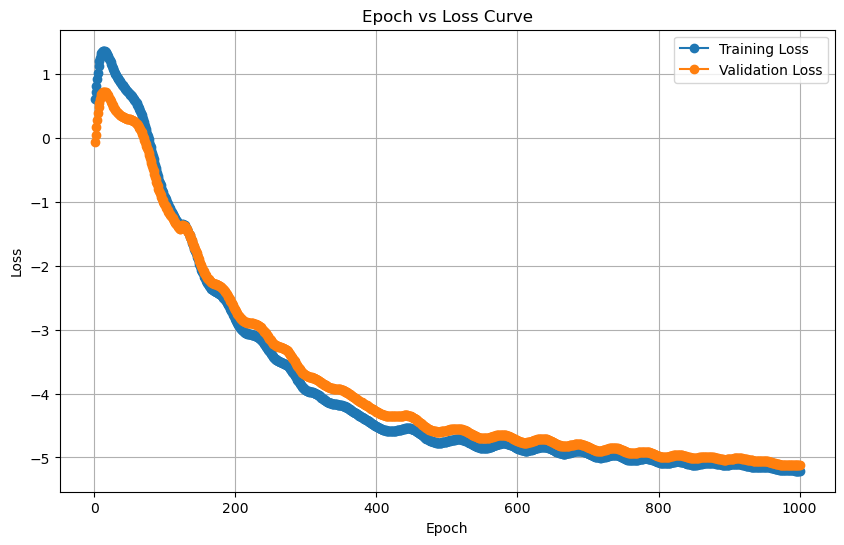

In [338]:
# Extracting epochs, training loss, and validation loss
epochs = [entry['epoch'] for entry in net.history]
train_losses = [entry['train_loss'] for entry in net.history]
valid_losses = [entry['valid_loss'] for entry in net.history]

# Plotting the epoch vs loss curve
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, valid_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


In [222]:
train_loader.dataset.Y.shape

torch.Size([7499, 1])

In [ ]:
# dict_keys(['module', 'criterion', 'optimizer', 'lr', 'max_epochs', 'batch_size', 'iterator_train', 
#            'iterator_valid', 'dataset', 'train_split', 'callbacks', 'predict_nonlinearity', 'warm_start', 
#            'verbose', 'device', 'compile', 'use_caching', '_params_to_validate', 'history_', 'initialized_', 
#            'virtual_params_', 'alpha', 'init_context_', 'callbacks_', 'prefixes_', 'cuda_dependent_attributes_', 
#            '_modules', 'module_', '_criteria', 'criterion_', '_optimizers', 'optimizer_'])

In [343]:
encoder_outputs = net.predict(test_loader.dataset.X[:, :5])

In [348]:
df_X = pd.DataFrame(encoder_outputs, columns=[f'X{i+1}' for i in range(num_non_sensitive)])    
df_sens_Y = data_test.copy()[[f'S{i+1}' for i in range(num_sensitive)] + ['Y']].reset_index(drop=True)
new_df = pd.concat([df_X, df_sens_Y], axis=1)

In [349]:
new_df

,X1,X2,X3,X4,S1,Y
0,2.640185,-2.950221,-0.285199,0.216646,0,1
1,1.628056,-0.387941,-0.016694,-0.903676,1,1
2,4.467671,-4.123909,0.459615,-1.104669,1,0
3,1.352790,-2.360820,-0.402826,1.104381,1,1
4,3.752315,-2.708508,0.237911,-1.187450,0,1
...,...,...,...,...,...,...
1495,0.808999,-0.341113,-0.159548,-0.112377,1,0
1496,1.274529,-1.752681,-0.263791,0.642488,1,0
1497,0.928265,-2.067095,-0.159077,0.836260,0,1
1498,2.231003,-3.374362,-0.151177,0.637438,1,1


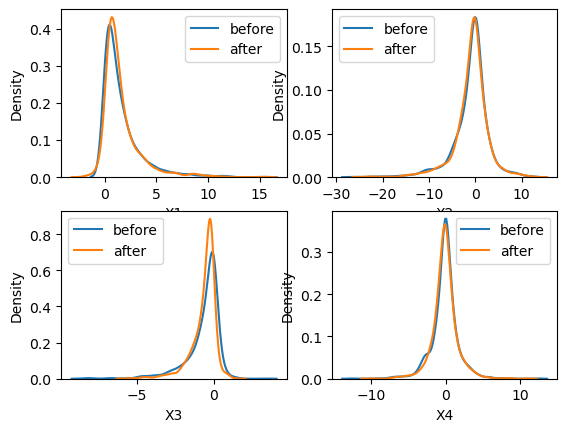

In [350]:
# _ = plt.figure()
# ax = plt.gca()

fig, ax = plt.subplots(2,2)
ax = ax.reshape(-1)

plt.subplot(2,2,1)
sns.kdeplot(data_test['X1'], ax=ax[0])
sns.kdeplot(new_df['X1'], ax=ax[0])
ax[0].legend(['before','after'])

plt.subplot(2,2,2)
sns.kdeplot(data_test['X2'], ax=ax[1])
sns.kdeplot(new_df['X2'], ax=ax[1])
ax[1].legend(['before','after'])

plt.subplot(2,2,3)
sns.kdeplot(data_test['X3'], ax=ax[2])
sns.kdeplot(new_df['X3'], ax=ax[2])
ax[2].legend(['before','after'])

plt.subplot(2,2,4)
sns.kdeplot(data_test['X4'], ax=ax[3])
sns.kdeplot(new_df['X4'], ax=ax[3])
ax[3].legend(['before','after'])

plt.show()

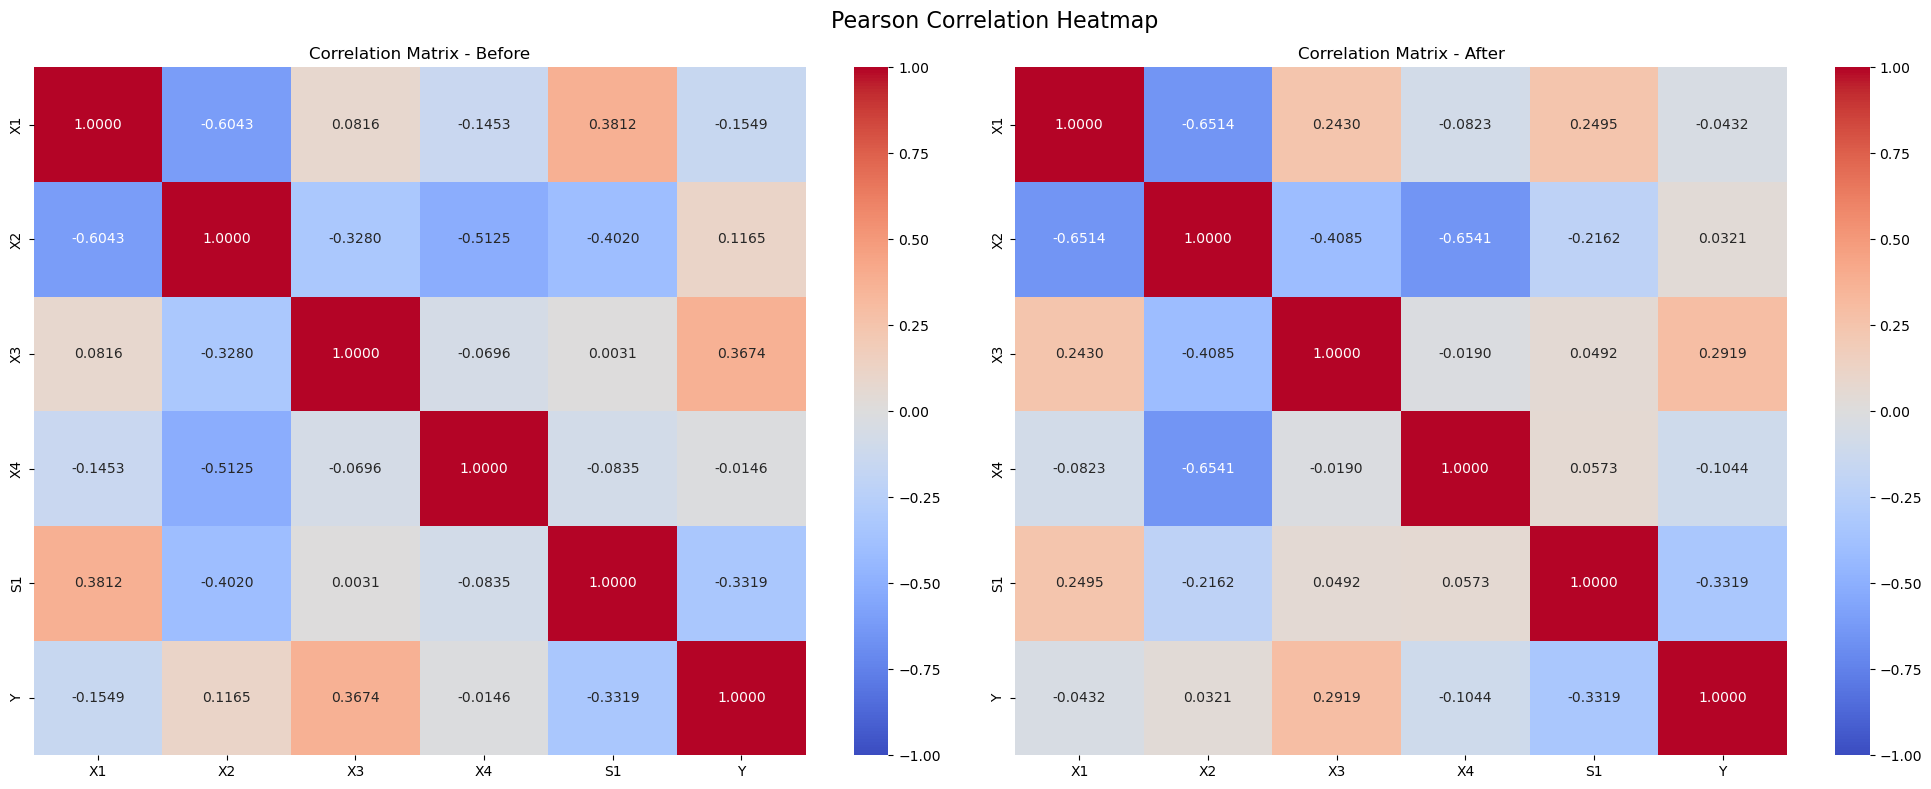

In [351]:
plot_comparison_heatmaps(data_test, new_df, figsize=(20, 8), cmap='coolwarm', vmin=-1, vmax=1)

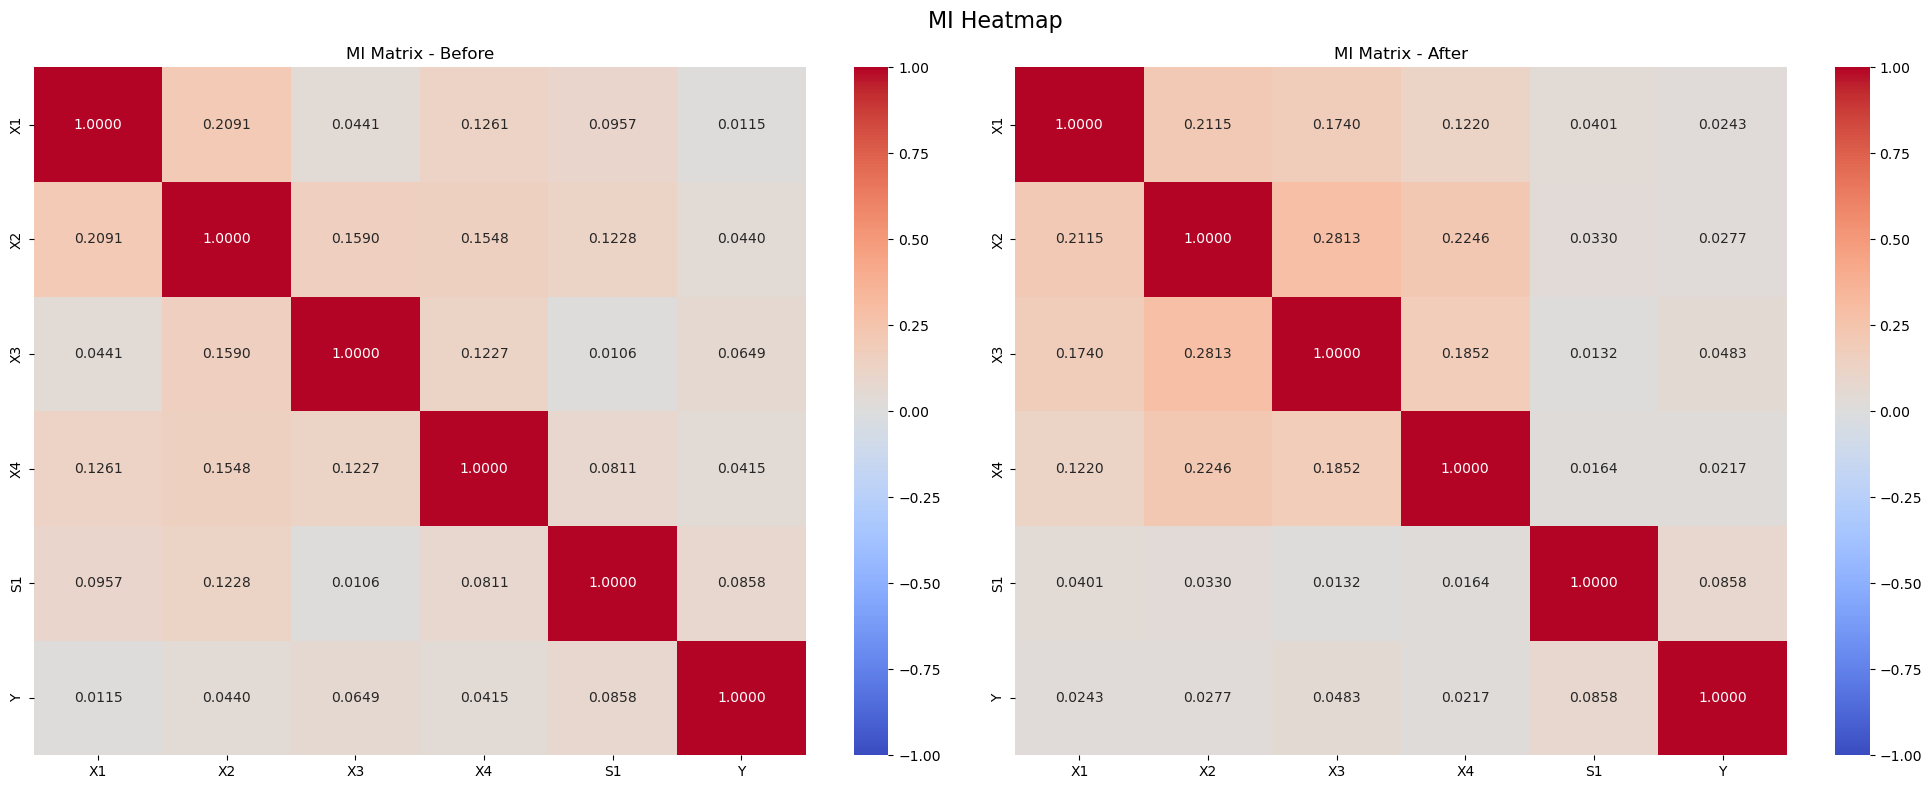

In [352]:
plt.figure(figsize=(20,8))

plt.subplot(1, 2, 1)
sns.heatmap(mutual_info_matrix(data_test), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('MI Matrix - Before')

plt.subplot(1, 2, 2)
sns.heatmap(mutual_info_matrix(new_df), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('MI Matrix - After')

plt.suptitle('MI Heatmap', fontsize=16)

plt.tight_layout()
plt.show()

In [353]:
y_true, y_logits, y_pred = get_predictions(data_test, num_non_sensitive, num_sensitive, encoder, predictor, threshold=0.5)

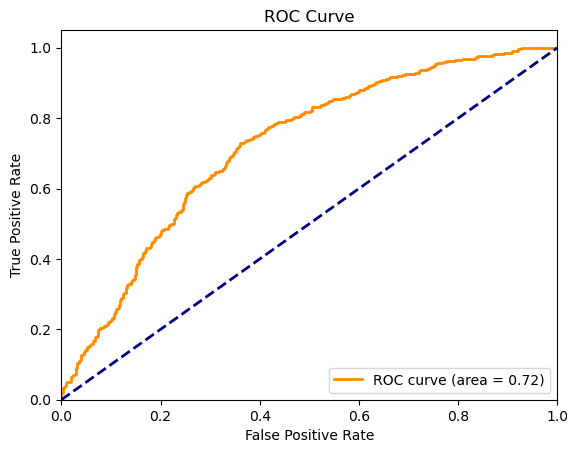

In [354]:
plot_auc_roc_curve(y_true, y_logits, title='ROC Curve')

In [355]:
np.unique(y_true, return_counts=True)

(array([0, 1]), array([ 433, 1067]))

In [356]:
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([ 170, 1330]))

In [357]:
metrics = evaluate_classifier(y_true, y_pred, y_logits)

for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Accuracy: 0.7447
Precision: 0.7571
Recall: 0.9438
F1 Score: 0.8402
ROC AUC Score: 0.7214


In [358]:
all_group_stats, all_demographic_parity = get_demographic_parity(y_true, y_pred, data_test, num_sensitive)

for sensitive_var, stat in all_group_stats.items():
    print(f"Group stats for sensitive variable: {sensitive_var}")
    print(stat)

    print('\n\n')

for sensitive_var, dp in all_demographic_parity.items():
    print(f"Demographic parity for sensitive variable: {sensitive_var}")
    print(dp)


Group stats for sensitive variable: S1
    total_predictions  positive_predictions  positive_prediction_rate
S1                                                                   
0                 924                   833                  0.901515
1                 576                   497                  0.862847



Demographic parity for sensitive variable: S1
0.03866792929292928


In [359]:
new_df_train, new_df_test = perform_train_test_split(new_df, num_non_sensitive=num_non_sensitive, num_sensitive=num_sensitive, test_size=0.2,random_state=69)

print(new_df_train.shape, new_df_test.shape)

(1200, 6) (300, 6)


In [360]:
X_train, Y_train = new_df_train[['X1', 'X2', 'X3', 'X4']], new_df_train[['Y']]
X_test, Y_test = new_df_test[['X1', 'X2', 'X3', 'X4']], new_df_test[['Y']]
model_after = train_xgb_classifier(X_train, Y_train, seed=69)

Y_pred = model_after.predict(X_test)
Y_test = np.array(Y_test).reshape(-1)
Y_probs = model_after.predict_proba(X_test)

print(roc_auc_score(Y_test,Y_probs[:, 1]))

0.671121997976463


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:50:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [361]:
import optuna
from fairness.xgb_optuna import objective
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train, X_test, Y_train, Y_test), n_trials=100)

[I 2024-12-11 16:50:25,245] A new study created in memory with name: no-name-d4584e3f-3204-4b6b-9575-f5291edb76a1
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  '

Trial 0:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.050116086246084844, 'n_estimators': 480, 'subsample': 0.9543542288281559, 'colsample_bytree': 0.9600744177145972, 'gamma': 0.03666952426889519, 'min_child_weight': 7}
Accuracy: 0.74, Precision: 0.7759336099585062, Recall: 0.8862559241706162, F1-score: 0.827433628318584, AUC: 0.7110602268491398
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 1:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.02112024478391993, 'n_estimators': 218, 'subsample': 0.7940868730031098, 'colsample_bytree': 0.8491803963006477, 'gamma': 0.25244168984479365, 'min_child_weight': 9}
Accuracy: 0.7233333333333334, Precision: 0.756, Recall: 0.8957345971563981, F1-score: 0.8199566160520607, AUC: 0.7131902657223494
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 2:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.10898206592224405, 'n_estimators': 407, 'subsample': 0.8017767496997926, 'colsample_bytree': 0.8643336518965224, 'gamma': 0.1817306449170678, 'min_child_weight': 2}
Accuracy: 0.69, Precision: 0.7543103448275862, Recall: 0.8293838862559242, F1-score: 0.7900677200902935, AUC: 0.6755418286383725
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 3:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.13507354395150353, 'n_estimators': 410, 'subsample': 0.7434882714567033, 'colsample_bytree': 0.9664721325169758, 'gamma': 0.3343799578175643, 'min_child_weight': 1}
Accuracy: 0.6866666666666666, Precision: 0.7554585152838428, Recall: 0.8199052132701422, F1-score: 0.7863636363636364, AUC: 0.6579690079343948
--------------------------------------------------
Trial 4:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.014421322975512626, 'n_estimators': 243, 'subsample': 0.7887870108878402, 'colsample_bytree': 0.9453215510463906, 'gamma': 0.28546854936156985, 'min_child_weight': 10}
Accuracy: 0.7133333333333334, Precision: 0.7413127413127413, Recall: 0.909952606635071, F1-score: 0.8170212765957446, AUC: 0.7083710527717132
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 5:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.024383213337715044, 'n_estimators': 388, 'subsample': 0.9248271096843257, 'colsample_bytree': 0.8851077817777793, 'gamma': 0.04224578097804327, 'min_child_weight': 4}
Accuracy: 0.7366666666666667, Precision: 0.7661290322580645, Recall: 0.9004739336492891, F1-score: 0.8278867102396514, AUC: 0.71106022684914
--------------------------------------------------


[I 2024-12-11 16:50:26,674] Trial 6 finished with value: 0.7098887054688748 and parameters: {'max_depth': 4, 'learning_rate': 0.04510238242725981, 'n_estimators': 280, 'subsample': 0.8544192767129204, 'colsample_bytree': 0.9221784933649578, 'gamma': 0.1470764162877251, 'min_child_weight': 8}. Best is trial 1 with value: 0.7131902657223494.


Trial 6:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.04510238242725981, 'n_estimators': 280, 'subsample': 0.8544192767129204, 'colsample_bytree': 0.9221784933649578, 'gamma': 0.1470764162877251, 'min_child_weight': 8}
Accuracy: 0.72, Precision: 0.7613168724279835, Recall: 0.8767772511848341, F1-score: 0.8149779735682819, AUC: 0.7098887054688748
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 7:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.023677401924153775, 'n_estimators': 430, 'subsample': 0.9411363738961297, 'colsample_bytree': 0.7493914660414371, 'gamma': 0.15438246696230834, 'min_child_weight': 1}
Accuracy: 0.6966666666666667, Precision: 0.7564102564102564, Recall: 0.8388625592417062, F1-score: 0.7955056179775281, AUC: 0.6803344161030939
--------------------------------------------------
Trial 8:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.28778655781196993, 'n_estimators': 231, 'subsample': 0.9889347093992804, 'colsample_bytree': 0.8769691610458361, 'gamma': 0.0283455329171709, 'min_child_weight': 4}
Accuracy: 0.69, Precision: 0.7610619469026548, Recall: 0.8151658767772512, F1-score: 0.7871853546910755, AUC: 0.672932531018691
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 9:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.1350203814262301, 'n_estimators': 392, 'subsample': 0.842528691563144, 'colsample_bytree': 0.9183560475456475, 'gamma': 0.37445841721237, 'min_child_weight': 3}
Accuracy: 0.6833333333333333, Precision: 0.7566371681415929, Recall: 0.8104265402843602, F1-score: 0.782608695652174, AUC: 0.6808669258213963
--------------------------------------------------
Trial 10:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.010223800693469407, 'n_estimators': 115, 'subsample': 0.7076240011619815, 'colsample_bytree': 0.7794375476867674, 'gamma': 0.4999969833538181, 'min_child_weight': 10}
Accuracy: 0.7333333333333333, Precision: 0.7364620938628159, Recall: 0.966824644549763, F1-score: 0.8360655737704918, AUC: 0.7034719633633313
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 11:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.024739252299910888, 'n_estimators': 173, 'subsample': 0.8977911432508969, 'colsample_bytree': 0.8110065448846454, 'gamma': 0.2522702383415715, 'min_child_weight': 5}
Accuracy: 0.7266666666666667, Precision: 0.7509727626459144, Recall: 0.9146919431279621, F1-score: 0.8247863247863247, AUC: 0.7117791149688483
--------------------------------------------------
Trial 12:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.025562384091567573, 'n_estimators': 146, 'subsample': 0.8796763073842728, 'colsample_bytree': 0.8101204910541935, 'gamma': 0.23717165650123417, 'min_child_weight': 6}
Accuracy: 0.7266666666666667, Precision: 0.7611336032388664, Recall: 0.8909952606635071, F1-score: 0.8209606986899564, AUC: 0.713083763778689
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 13:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.030240805451895662, 'n_estimators': 114, 'subsample': 0.8713012122015661, 'colsample_bytree': 0.7035319020219841, 'gamma': 0.4089019344109696, 'min_child_weight': 7}
Accuracy: 0.7266666666666667, Precision: 0.7549407114624506, Recall: 0.9052132701421801, F1-score: 0.8232758620689655, AUC: 0.711699238511103
--------------------------------------------------


[I 2024-12-11 16:50:27,917] Trial 14 finished with value: 0.7117791149688482 and parameters: {'max_depth': 6, 'learning_rate': 0.015515744734879374, 'n_estimators': 182, 'subsample': 0.8035219415445339, 'colsample_bytree': 0.8093662555848676, 'gamma': 0.20789595858785745, 'min_child_weight': 8}. Best is trial 1 with value: 0.7131902657223494.
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


Trial 14:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.015515744734879374, 'n_estimators': 182, 'subsample': 0.8035219415445339, 'colsample_bytree': 0.8093662555848676, 'gamma': 0.20789595858785745, 'min_child_weight': 8}
Accuracy: 0.7133333333333334, Precision: 0.7450980392156863, Recall: 0.9004739336492891, F1-score: 0.8154506437768241, AUC: 0.7117791149688482
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'gamma': trial.suggest_uniform('gamma', 0, 0.5),
[I 2024-12-11 16:50:28,226] Trial 15 finished with value: 0.696842217370467 and p

Trial 15:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.07529145997621575, 'n_estimators': 319, 'subsample': 0.7567955398055937, 'colsample_bytree': 0.8232431586017711, 'gamma': 0.11074308617802209, 'min_child_weight': 6}
Accuracy: 0.7033333333333334, Precision: 0.7563025210084033, Recall: 0.8530805687203792, F1-score: 0.8017817371937639, AUC: 0.696842217370467
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 16:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.03626729574357523, 'n_estimators': 177, 'subsample': 0.8272065407101827, 'colsample_bytree': 0.7510835749223089, 'gamma': 0.285868006353186, 'min_child_weight': 9}
Accuracy: 0.7233333333333334, Precision: 0.7580645161290323, Recall: 0.8909952606635071, F1-score: 0.8191721132897604, AUC: 0.7064806432717398
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 17:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.015084512483893992, 'n_estimators': 325, 'subsample': 0.8839666611408157, 'colsample_bytree': 0.996700291483831, 'gamma': 0.2307069162016034, 'min_child_weight': 6}
Accuracy: 0.7333333333333333, Precision: 0.7651821862348178, Recall: 0.8957345971563981, F1-score: 0.8253275109170306, AUC: 0.713563022525161
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 18:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.01109575096971198, 'n_estimators': 341, 'subsample': 0.8927026279891536, 'colsample_bytree': 0.9830873019047313, 'gamma': 0.09569636095212383, 'min_child_weight': 8}
Accuracy: 0.7233333333333334, Precision: 0.7580645161290323, Recall: 0.8909952606635071, F1-score: 0.8191721132897604, AUC: 0.7130038873209436
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 19:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.017201026548499598, 'n_estimators': 261, 'subsample': 0.7785260718476267, 'colsample_bytree': 0.9161068031066782, 'gamma': 0.32038528909899533, 'min_child_weight': 9}
Accuracy: 0.72, Precision: 0.7529880478087649, Recall: 0.8957345971563981, F1-score: 0.8181818181818182, AUC: 0.7090366899195911
--------------------------------------------------
Trial 20:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.07430473817167259, 'n_estimators': 342, 'subsample': 0.7037787659071552, 'colsample_bytree': 0.998428487565818, 'gamma': 0.41126184910737473, 'min_child_weight': 5}
Accuracy: 0.7033333333333334, Precision: 0.7606837606837606, Recall: 0.8436018957345972, F1-score: 0.8, AUC: 0.6918898769902551
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 21:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.01956573460802854, 'n_estimators': 214, 'subsample': 0.8815187883477694, 'colsample_bytree': 0.8405540599621576, 'gamma': 0.23398347444214915, 'min_child_weight': 6}
Accuracy: 0.7266666666666667, Precision: 0.7590361445783133, Recall: 0.8957345971563981, F1-score: 0.8217391304347826, AUC: 0.7134565205815007
--------------------------------------------------
Trial 22:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.017867229596506738, 'n_estimators': 220, 'subsample': 0.8280919173582503, 'colsample_bytree': 0.8411187694949587, 'gamma': 0.21842824273002576, 'min_child_weight': 7}
Accuracy: 0.7266666666666667, Precision: 0.7590361445783133, Recall: 0.8957345971563981, F1-score: 0.8217391304347826, AUC: 0.7123382501730656
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 23:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.012588002249155725, 'n_estimators': 304, 'subsample': 0.910263796816561, 'colsample_bytree': 0.848029492015417, 'gamma': 0.2782286124313664, 'min_child_weight': 4}
Accuracy: 0.73, Precision: 0.7642276422764228, Recall: 0.8909952606635071, F1-score: 0.8227571115973742, AUC: 0.7078651685393258
--------------------------------------------------
Trial 24:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.01933226578934581, 'n_estimators': 210, 'subsample': 0.8595999670499217, 'colsample_bytree': 0.8916925554667392, 'gamma': 0.19670468278299647, 'min_child_weight': 6}
Accuracy: 0.7266666666666667, Precision: 0.763265306122449, Recall: 0.8862559241706162, F1-score: 0.8201754385964912, AUC: 0.7169710847222963
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 25:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.03565347599963837, 'n_estimators': 274, 'subsample': 0.8581676062217088, 'colsample_bytree': 0.8973768848994798, 'gamma': 0.18256286559634421, 'min_child_weight': 6}
Accuracy: 0.7266666666666667, Precision: 0.763265306122449, Recall: 0.8862559241706162, F1-score: 0.8201754385964912, AUC: 0.7077586665956654
--------------------------------------------------
Trial 26:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.01930952506482222, 'n_estimators': 204, 'subsample': 0.9647945069510042, 'colsample_bytree': 0.9401267062473209, 'gamma': 0.08863268720150105, 'min_child_weight': 5}
Accuracy: 0.7266666666666667, Precision: 0.7611336032388664, Recall: 0.8909952606635071, F1-score: 0.8209606986899564, AUC: 0.7139357793279728
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 27:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.013892716619577583, 'n_estimators': 357, 'subsample': 0.999010395521025, 'colsample_bytree': 0.9496454173694936, 'gamma': 0.10308310050600233, 'min_child_weight': 5}
Accuracy: 0.7166666666666667, Precision: 0.7647058823529411, Recall: 0.8625592417061612, F1-score: 0.8106904231625836, AUC: 0.712631130518132
--------------------------------------------------
Trial 28:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.031774442751851345, 'n_estimators': 142, 'subsample': 0.9627167120796719, 'colsample_bytree': 0.9967929589578638, 'gamma': 0.07376976836125804, 'min_child_weight': 3}
Accuracy: 0.7233333333333334, Precision: 0.7622950819672131, Recall: 0.8815165876777251, F1-score: 0.8175824175824176, AUC: 0.7101017093561958
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 29:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.05020829395280996, 'n_estimators': 478, 'subsample': 0.9629876323090634, 'colsample_bytree': 0.974028674214324, 'gamma': 0.1397402156131917, 'min_child_weight': 7}
Accuracy: 0.73, Precision: 0.7801724137931034, Recall: 0.8578199052132701, F1-score: 0.8171557562076749, AUC: 0.7050428670323233
--------------------------------------------------
Trial 30:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.043420731991105826, 'n_estimators': 199, 'subsample': 0.9268064836802408, 'colsample_bytree': 0.9335617394670936, 'gamma': 0.0626637790278402, 'min_child_weight': 5}
Accuracy: 0.73, Precision: 0.7754237288135594, Recall: 0.8672985781990521, F1-score: 0.8187919463087249, AUC: 0.7090899408914213
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 31:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.019102475341717856, 'n_estimators': 253, 'subsample': 0.8777328502913194, 'colsample_bytree': 0.8916618429669474, 'gamma': 0.1908337167536255, 'min_child_weight': 6}
Accuracy: 0.73, Precision: 0.7620967741935484, Recall: 0.8957345971563981, F1-score: 0.8235294117647058, AUC: 0.7119654933702539
--------------------------------------------------
Trial 32:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.020558449567961844, 'n_estimators': 202, 'subsample': 0.9067965553358882, 'colsample_bytree': 0.9033994772125357, 'gamma': 0.22955110610477986, 'min_child_weight': 6}
Accuracy: 0.7266666666666667, Precision: 0.7590361445783133, Recall: 0.8957345971563981, F1-score: 0.8217391304347826, AUC: 0.7144150380744448
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 33:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.01300625897900787, 'n_estimators': 155, 'subsample': 0.9762099452297394, 'colsample_bytree': 0.9051949830425874, 'gamma': 0.16526520593831834, 'min_child_weight': 4}
Accuracy: 0.71, Precision: 0.746031746031746, Recall: 0.8909952606635071, F1-score: 0.8120950323974082, AUC: 0.7079982959689014
--------------------------------------------------


[I 2024-12-11 16:50:31,924] Trial 34 finished with value: 0.7135630225251611 and parameters: {'max_depth': 4, 'learning_rate': 0.02178389985186061, 'n_estimators': 290, 'subsample': 0.9402377580916645, 'colsample_bytree': 0.9520195126493137, 'gamma': 0.006088829979587096, 'min_child_weight': 7}. Best is trial 24 with value: 0.7169710847222963.
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/

Trial 34:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.02178389985186061, 'n_estimators': 290, 'subsample': 0.9402377580916645, 'colsample_bytree': 0.9520195126493137, 'gamma': 0.006088829979587096, 'min_child_weight': 7}
Accuracy: 0.73, Precision: 0.7620967741935484, Recall: 0.8957345971563981, F1-score: 0.8235294117647058, AUC: 0.7135630225251611
--------------------------------------------------
Trial 35:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.0211010423347676, 'n_estimators': 290, 'subsample': 0.9435660091161623, 'colsample_bytree': 0.867191964453996, 'gamma': 0.014092946301299356, 'min_child_weight': 7}
Accuracy: 0.73, Precision: 0.7620967741935484, Recall: 0.8957345971563981, F1-score: 0.8235294117647058, AUC: 0.7130305128068587
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 36:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.0629385731719166, 'n_estimators': 202, 'subsample': 0.9134825913475164, 'colsample_bytree': 0.9498641027936039, 'gamma': 0.001530287418299331, 'min_child_weight': 8}
Accuracy: 0.7266666666666667, Precision: 0.7654320987654321, Recall: 0.8815165876777251, F1-score: 0.8193832599118943, AUC: 0.714681292933596
--------------------------------------------------
Trial 37:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.062299554986234025, 'n_estimators': 199, 'subsample': 0.9129515915217179, 'colsample_bytree': 0.9344660596483351, 'gamma': 0.05759087970354682, 'min_child_weight': 8}
Accuracy: 0.73, Precision: 0.7663934426229508, Recall: 0.8862559241706162, F1-score: 0.8219780219780219, AUC: 0.7128441344054528
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 38:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.08746883767370424, 'n_estimators': 235, 'subsample': 0.9082250643189613, 'colsample_bytree': 0.9629353477354077, 'gamma': 0.1230932834013457, 'min_child_weight': 3}
Accuracy: 0.7233333333333334, Precision: 0.7711864406779662, Recall: 0.8625592417061612, F1-score: 0.814317673378076, AUC: 0.6940731668352947
--------------------------------------------------
Trial 39:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.05842821344393268, 'n_estimators': 161, 'subsample': 0.9248056933062736, 'colsample_bytree': 0.9338945131451571, 'gamma': 0.08008952114330674, 'min_child_weight': 9}
Accuracy: 0.7266666666666667, Precision: 0.763265306122449, Recall: 0.8862559241706162, F1-score: 0.8201754385964912, AUC: 0.7082379253421375
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 40:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.20696145770849303, 'n_estimators': 200, 'subsample': 0.9524702914604067, 'colsample_bytree': 0.8769413631533547, 'gamma': 0.03784514913408299, 'min_child_weight': 5}
Accuracy: 0.6966666666666667, Precision: 0.7678571428571429, Recall: 0.8151658767772512, F1-score: 0.7908045977011494, AUC: 0.6902390968635177
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'gamma': trial.suggest_uniform('gamma', 0, 0.5),
[I 2024-12-11 16:50:33,142] Trial 41 finished with value: 0.7172373395814474 and parameters: {'max_depth': 4, 'learning_rate': 0.029476568447161913, 'n_estimators': 255, 'subsample': 0.9357079695301964, 'colsample_bytree': 0.9526157442723067, 'gamma': 0.008456425392524392, 'min_child_weight': 7}. Best is trial 41 with value: 0.7172373395814474.
/home/ec2-user/SageMaker/Bias/fairness/

Trial 41:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.029476568447161913, 'n_estimators': 255, 'subsample': 0.9357079695301964, 'colsample_bytree': 0.9526157442723067, 'gamma': 0.008456425392524392, 'min_child_weight': 7}
Accuracy: 0.7333333333333333, Precision: 0.7651821862348178, Recall: 0.8957345971563981, F1-score: 0.8253275109170306, AUC: 0.7172373395814474
--------------------------------------------------
Trial 42:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.028380413137634255, 'n_estimators': 258, 'subsample': 0.9750867559862035, 'colsample_bytree': 0.9169843849404148, 'gamma': 0.004089756289199718, 'min_child_weight': 7}
Accuracy: 0.7266666666666667, Precision: 0.7590361445783133, Recall: 0.8957345971563981, F1-score: 0.8217391304347826, AUC: 0.7155333084828798
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 43:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.030468042718542598, 'n_estimators': 249, 'subsample': 0.9850943971772186, 'colsample_bytree': 0.9084145593626444, 'gamma': 0.004416485459909763, 'min_child_weight': 8}
Accuracy: 0.7266666666666667, Precision: 0.7590361445783133, Recall: 0.8957345971563981, F1-score: 0.8217391304347826, AUC: 0.7137227754406518
--------------------------------------------------
Trial 44:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.04049857302340593, 'n_estimators': 231, 'subsample': 0.8633829261604473, 'colsample_bytree': 0.9228765892916473, 'gamma': 0.04111025863870901, 'min_child_weight': 7}
Accuracy: 0.72, Precision: 0.7550200803212851, Recall: 0.8909952606635071, F1-score: 0.8173913043478261, AUC: 0.7145747909899356
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 45:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.04382674344706507, 'n_estimators': 268, 'subsample': 0.8351963480644607, 'colsample_bytree': 0.9269047705493815, 'gamma': 0.035854279113090914, 'min_child_weight': 7}
Accuracy: 0.7266666666666667, Precision: 0.763265306122449, Recall: 0.8862559241706162, F1-score: 0.8201754385964912, AUC: 0.7111667287928005
--------------------------------------------------
Trial 46:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.03643619994917616, 'n_estimators': 238, 'subsample': 0.8606279795391887, 'colsample_bytree': 0.9762363094472897, 'gamma': 0.021870439866875237, 'min_child_weight': 8}
Accuracy: 0.7266666666666667, Precision: 0.7611336032388664, Recall: 0.8909952606635071, F1-score: 0.8209606986899564, AUC: 0.7114063581660365
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 47:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.02732223653630421, 'n_estimators': 233, 'subsample': 0.9300077563185063, 'colsample_bytree': 0.956366977837899, 'gamma': 0.041418699640025036, 'min_child_weight': 10}
Accuracy: 0.7233333333333334, Precision: 0.7519685039370079, Recall: 0.9052132701421801, F1-score: 0.821505376344086, AUC: 0.7147877948772565
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 48:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.030047695239761075, 'n_estimators': 127, 'subsample': 0.9258068345737672, 'colsample_bytree': 0.9566631200453785, 'gamma': 3.60743635305482e-05, 'min_child_weight': 9}
Accuracy: 0.7233333333333334, Precision: 0.7424242424242424, Recall: 0.9289099526066351, F1-score: 0.8252631578947368, AUC: 0.709276319292827
--------------------------------------------------
Trial 49:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.02531575726569744, 'n_estimators': 187, 'subsample': 0.9756362719262244, 'colsample_bytree': 0.8844621056749533, 'gamma': 0.059289766511977336, 'min_child_weight': 10}
Accuracy: 0.7133333333333334, Precision: 0.7450980392156863, Recall: 0.9004739336492891, F1-score: 0.8154506437768241, AUC: 0.71220512274349
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 50:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.02765551554100907, 'n_estimators': 308, 'subsample': 0.9420936162961754, 'colsample_bytree': 0.970667705507138, 'gamma': 0.12795351405819452, 'min_child_weight': 10}
Accuracy: 0.72, Precision: 0.7550200803212851, Recall: 0.8909952606635071, F1-score: 0.8173913043478261, AUC: 0.7132168912082645
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 51:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.03968524369796347, 'n_estimators': 223, 'subsample': 0.8483478478289699, 'colsample_bytree': 0.9133271119240944, 'gamma': 0.04230204723004671, 'min_child_weight': 7}
Accuracy: 0.7166666666666667, Precision: 0.7540322580645161, Recall: 0.8862559241706162, F1-score: 0.8148148148148148, AUC: 0.7153203045955588
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 52:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.05525213157383542, 'n_estimators': 223, 'subsample': 0.847890963233377, 'colsample_bytree': 0.9170143180186623, 'gamma': 0.051547504551267484, 'min_child_weight': 8}
Accuracy: 0.7166666666666667, Precision: 0.7560975609756098, Recall: 0.8815165876777251, F1-score: 0.8140043763676149, AUC: 0.7129506363491134
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 53:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.05001988834670262, 'n_estimators': 255, 'subsample': 0.8199277288518035, 'colsample_bytree': 0.9460194125775093, 'gamma': 0.02656486292187797, 'min_child_weight': 7}
Accuracy: 0.73, Precision: 0.7620967741935484, Recall: 0.8957345971563981, F1-score: 0.8235294117647058, AUC: 0.7107939719899888
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 54:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.10982011307118916, 'n_estimators': 171, 'subsample': 0.809162502905243, 'colsample_bytree': 0.9834638941081999, 'gamma': 0.02243365943178234, 'min_child_weight': 9}
Accuracy: 0.7233333333333334, Precision: 0.7666666666666667, Recall: 0.8720379146919431, F1-score: 0.8159645232815964, AUC: 0.7013152990042067
--------------------------------------------------
Trial 55:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.07020731389546767, 'n_estimators': 276, 'subsample': 0.8923300952464974, 'colsample_bytree': 0.9629927479275315, 'gamma': 0.48570632109381645, 'min_child_weight': 8}
Accuracy: 0.7266666666666667, Precision: 0.763265306122449, Recall: 0.8862559241706162, F1-score: 0.8201754385964912, AUC: 0.7084509292294584
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 56:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.03426735175255815, 'n_estimators': 242, 'subsample': 0.9326187972527267, 'colsample_bytree': 0.9440096125811391, 'gamma': 0.06477174644089916, 'min_child_weight': 7}
Accuracy: 0.7333333333333333, Precision: 0.7673469387755102, Recall: 0.8909952606635071, F1-score: 0.8245614035087719, AUC: 0.7119921188561691
--------------------------------------------------
Trial 57:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.027288047818508052, 'n_estimators': 214, 'subsample': 0.8717269492836015, 'colsample_bytree': 0.8575887110940954, 'gamma': 0.04546823105700905, 'min_child_weight': 9}
Accuracy: 0.7166666666666667, Precision: 0.752, Recall: 0.8909952606635071, F1-score: 0.8156182212581344, AUC: 0.7118589914265936
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 58:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.02360808880671753, 'n_estimators': 265, 'subsample': 0.7793821976509432, 'colsample_bytree': 0.9113426716998947, 'gamma': 0.08652148827816314, 'min_child_weight': 6}
Accuracy: 0.7233333333333334, Precision: 0.7580645161290323, Recall: 0.8909952606635071, F1-score: 0.8191721132897604, AUC: 0.7095691996378933
--------------------------------------------------
Trial 59:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.03984366993261292, 'n_estimators': 185, 'subsample': 0.9542957780641181, 'colsample_bytree': 0.8782030800372793, 'gamma': 0.0007343103124217848, 'min_child_weight': 8}
Accuracy: 0.73, Precision: 0.7663934426229508, Recall: 0.8862559241706162, F1-score: 0.8219780219780219, AUC: 0.7174237179828532
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 60:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.040724022388449105, 'n_estimators': 189, 'subsample': 0.9529429978902357, 'colsample_bytree': 0.8731288198454478, 'gamma': 0.3322808062766982, 'min_child_weight': 10}
Accuracy: 0.7166666666666667, Precision: 0.7560975609756098, Recall: 0.8815165876777251, F1-score: 0.8140043763676149, AUC: 0.7139624048138878
--------------------------------------------------
Trial 61:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.04886140719574984, 'n_estimators': 231, 'subsample': 0.9735899709298984, 'colsample_bytree': 0.8928886179164334, 'gamma': 0.01829648550759569, 'min_child_weight': 8}
Accuracy: 0.7333333333333333, Precision: 0.7695473251028807, Recall: 0.8862559241706162, F1-score: 0.8237885462555066, AUC: 0.7111933542787157
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 62:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.03704161460321354, 'n_estimators': 217, 'subsample': 0.9162607822965593, 'colsample_bytree': 0.8838422243169992, 'gamma': 0.004337431807788483, 'min_child_weight': 7}
Accuracy: 0.7366666666666667, Precision: 0.7727272727272727, Recall: 0.8862559241706162, F1-score: 0.82560706401766, AUC: 0.7167580808349753
--------------------------------------------------
Trial 63:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.038470606650330044, 'n_estimators': 217, 'subsample': 0.8994376212919124, 'colsample_bytree': 0.8857653258231597, 'gamma': 0.03091326957586128, 'min_child_weight': 6}
Accuracy: 0.7333333333333333, Precision: 0.7673469387755102, Recall: 0.8909952606635071, F1-score: 0.8245614035087719, AUC: 0.7127110069758774
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 64:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.03220985190859778, 'n_estimators': 166, 'subsample': 0.9920143123690872, 'colsample_bytree': 0.8957351282350751, 'gamma': 0.10603315886012162, 'min_child_weight': 7}
Accuracy: 0.7266666666666667, Precision: 0.7590361445783133, Recall: 0.8957345971563981, F1-score: 0.8217391304347826, AUC: 0.7111933542787156
--------------------------------------------------
Trial 65:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.027794524199861406, 'n_estimators': 283, 'subsample': 0.9541481891263873, 'colsample_bytree': 0.862155365811552, 'gamma': 0.07461719437262457, 'min_child_weight': 7}
Accuracy: 0.7266666666666667, Precision: 0.763265306122449, Recall: 0.8862559241706162, F1-score: 0.8201754385964912, AUC: 0.7095159486660632
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 66:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.022886077926656936, 'n_estimators': 247, 'subsample': 0.7324992891017642, 'colsample_bytree': 0.8338760915599601, 'gamma': 0.26979370334636216, 'min_child_weight': 6}
Accuracy: 0.7233333333333334, Precision: 0.7580645161290323, Recall: 0.8909952606635071, F1-score: 0.8191721132897604, AUC: 0.7039245966238884
--------------------------------------------------
Trial 67:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.035359097902889415, 'n_estimators': 182, 'subsample': 0.9364959212564953, 'colsample_bytree': 0.9289406493739389, 'gamma': 0.046684560349526526, 'min_child_weight': 7}
Accuracy: 0.7366666666666667, Precision: 0.7682926829268293, Recall: 0.8957345971563981, F1-score: 0.8271334792122538, AUC: 0.7145747909899355
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 68:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.027527652299506364, 'n_estimators': 143, 'subsample': 0.9209488340073105, 'colsample_bytree': 0.8528860852487413, 'gamma': 0.017176290021212504, 'min_child_weight': 6}
Accuracy: 0.72, Precision: 0.7529880478087649, Recall: 0.8957345971563981, F1-score: 0.8181818181818182, AUC: 0.7072261568773631
--------------------------------------------------


[I 2024-12-11 16:50:38,736] Trial 69 finished with value: 0.7168912082645508 and parameters: {'max_depth': 4, 'learning_rate': 0.01550128992226488, 'n_estimators': 221, 'subsample': 0.9648991198426135, 'colsample_bytree': 0.8692756415636936, 'gamma': 0.16788348910175363, 'min_child_weight': 9}. Best is trial 59 with value: 0.7174237179828532.
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/S

Trial 69:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.01550128992226488, 'n_estimators': 221, 'subsample': 0.9648991198426135, 'colsample_bytree': 0.8692756415636936, 'gamma': 0.16788348910175363, 'min_child_weight': 9}
Accuracy: 0.7366666666666667, Precision: 0.7558139534883721, Recall: 0.9241706161137441, F1-score: 0.8315565031982942, AUC: 0.7168912082645508
--------------------------------------------------
Trial 70:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.016549788771969085, 'n_estimators': 213, 'subsample': 0.9655770650063042, 'colsample_bytree': 0.8696578448229769, 'gamma': 0.19279366961214056, 'min_child_weight': 1}
Accuracy: 0.7233333333333334, Precision: 0.7601626016260162, Recall: 0.8862559241706162, F1-score: 0.8183807439824945, AUC: 0.7071729059055327
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 71:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.011549457574819027, 'n_estimators': 256, 'subsample': 0.9818616220858501, 'colsample_bytree': 0.8836827105242183, 'gamma': 0.1719332589514359, 'min_child_weight': 10}
Accuracy: 0.7266666666666667, Precision: 0.749034749034749, Recall: 0.919431279620853, F1-score: 0.825531914893617, AUC: 0.7135630225251611
--------------------------------------------------
Trial 72:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.01776413562971664, 'n_estimators': 224, 'subsample': 0.9474254476573063, 'colsample_bytree': 0.9016847877741108, 'gamma': 0.016246524773998603, 'min_child_weight': 9}
Accuracy: 0.72, Precision: 0.7529880478087649, Recall: 0.8957345971563981, F1-score: 0.8181818181818182, AUC: 0.7157995633420309
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 73:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.014852701168121756, 'n_estimators': 224, 'subsample': 0.945293738645621, 'colsample_bytree': 0.9003577885168057, 'gamma': 0.011880644911206762, 'min_child_weight': 9}
Accuracy: 0.7266666666666667, Precision: 0.7529411764705882, Recall: 0.909952606635071, F1-score: 0.8240343347639485, AUC: 0.7146280419617657
--------------------------------------------------
Trial 74:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.017785031291191113, 'n_estimators': 189, 'subsample': 0.9698633695022469, 'colsample_bytree': 0.8798575207897961, 'gamma': 0.15697739972143965, 'min_child_weight': 9}
Accuracy: 0.7266666666666667, Precision: 0.7509727626459144, Recall: 0.9146919431279621, F1-score: 0.8247863247863247, AUC: 0.7181159806166463
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 75:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.015059270402228844, 'n_estimators': 152, 'subsample': 0.9971972086826734, 'colsample_bytree': 0.8816531305742364, 'gamma': 0.1522230663851409, 'min_child_weight': 9}
Accuracy: 0.7333333333333333, Precision: 0.7434944237918215, Recall: 0.9478672985781991, F1-score: 0.8333333333333334, AUC: 0.7118589914265936
--------------------------------------------------
Trial 76:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.01779570357019283, 'n_estimators': 189, 'subsample': 0.9673051592959642, 'colsample_bytree': 0.8629070818018679, 'gamma': 0.20578784386738203, 'min_child_weight': 8}
Accuracy: 0.7233333333333334, Precision: 0.7519685039370079, Recall: 0.9052132701421801, F1-score: 0.821505376344086, AUC: 0.716252196602588
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 77:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.017182373623201675, 'n_estimators': 190, 'subsample': 0.9598996993931899, 'colsample_bytree': 0.8267693877142612, 'gamma': 0.2149088830269001, 'min_child_weight': 8}
Accuracy: 0.73, Precision: 0.751937984496124, Recall: 0.919431279620853, F1-score: 0.8272921108742004, AUC: 0.7148676713350018
--------------------------------------------------
Trial 78:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.012325129138956475, 'n_estimators': 180, 'subsample': 0.9484491528562184, 'colsample_bytree': 0.8481596939932935, 'gamma': 0.19559183672360508, 'min_child_weight': 9}
Accuracy: 0.73, Precision: 0.7425373134328358, Recall: 0.943127962085308, F1-score: 0.8308977035490606, AUC: 0.7078917940252409
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 79:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.010219458825995217, 'n_estimators': 130, 'subsample': 0.9571457456336427, 'colsample_bytree': 0.8614747820810384, 'gamma': 0.1679480427471494, 'min_child_weight': 9}
Accuracy: 0.73, Precision: 0.7355072463768116, Recall: 0.9620853080568721, F1-score: 0.8336755646817249, AUC: 0.7081580488843923
--------------------------------------------------
Trial 80:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.019112529903593193, 'n_estimators': 206, 'subsample': 0.9199946612620091, 'colsample_bytree': 0.8687761030535787, 'gamma': 0.24757652262905763, 'min_child_weight': 8}
Accuracy: 0.7233333333333334, Precision: 0.756, Recall: 0.8957345971563981, F1-score: 0.8199566160520607, AUC: 0.7140955322434634
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 81:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.01638052488567075, 'n_estimators': 209, 'subsample': 0.9665992650360314, 'colsample_bytree': 0.888845189460705, 'gamma': 0.20304497131244426, 'min_child_weight': 8}
Accuracy: 0.7333333333333333, Precision: 0.754863813229572, Recall: 0.919431279620853, F1-score: 0.8290598290598291, AUC: 0.7169710847222961
--------------------------------------------------
Trial 82:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.01634836593860256, 'n_estimators': 194, 'subsample': 0.9663484863430795, 'colsample_bytree': 0.8778498464983254, 'gamma': 0.1342280507604544, 'min_child_weight': 8}
Accuracy: 0.7333333333333333, Precision: 0.7509578544061303, Recall: 0.9289099526066351, F1-score: 0.8305084745762712, AUC: 0.7163054475744183
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 83:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.013600950370788569, 'n_estimators': 191, 'subsample': 0.9688490740901533, 'colsample_bytree': 0.7905926215490477, 'gamma': 0.20382945142634143, 'min_child_weight': 8}
Accuracy: 0.73, Precision: 0.7443609022556391, Recall: 0.9383886255924171, F1-score: 0.8301886792452831, AUC: 0.7151871771659833
--------------------------------------------------
Trial 84:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.016554927325754306, 'n_estimators': 160, 'subsample': 0.9828748569934906, 'colsample_bytree': 0.8556343259090868, 'gamma': 0.13567165559328617, 'min_child_weight': 8}
Accuracy: 0.7233333333333334, Precision: 0.7424242424242424, Recall: 0.9289099526066351, F1-score: 0.8252631578947368, AUC: 0.713110389264604
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 85:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.02094137743621891, 'n_estimators': 167, 'subsample': 0.9679200369487515, 'colsample_bytree': 0.8762467441114034, 'gamma': 0.17737275637833927, 'min_child_weight': 8}
Accuracy: 0.7266666666666667, Precision: 0.7549407114624506, Recall: 0.9052132701421801, F1-score: 0.8232758620689655, AUC: 0.7144949145321902
--------------------------------------------------
Trial 86:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.015965866631343247, 'n_estimators': 176, 'subsample': 0.9874468037250134, 'colsample_bytree': 0.8869281187054757, 'gamma': 0.15223043225522118, 'min_child_weight': 8}
Accuracy: 0.7233333333333334, Precision: 0.7461538461538462, Recall: 0.919431279620853, F1-score: 0.8237791932059448, AUC: 0.7170509611800415
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 87:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.011443995298906995, 'n_estimators': 209, 'subsample': 0.9904314374101596, 'colsample_bytree': 0.8897108910772612, 'gamma': 0.16171917824847726, 'min_child_weight': 8}
Accuracy: 0.73, Precision: 0.7425373134328358, Recall: 0.943127962085308, F1-score: 0.8308977035490606, AUC: 0.7136428989829063
--------------------------------------------------
Trial 88:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.015831916377627826, 'n_estimators': 104, 'subsample': 0.9788651428635786, 'colsample_bytree': 0.8415854565291396, 'gamma': 0.14912287589647683, 'min_child_weight': 9}
Accuracy: 0.7333333333333333, Precision: 0.73992673992674, Recall: 0.957345971563981, F1-score: 0.8347107438016529, AUC: 0.714228659673039
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 89:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.013790766075322874, 'n_estimators': 175, 'subsample': 0.9377222719448952, 'colsample_bytree': 0.8787019696819883, 'gamma': 0.117456608161966, 'min_child_weight': 9}
Accuracy: 0.73, Precision: 0.7425373134328358, Recall: 0.943127962085308, F1-score: 0.8308977035490606, AUC: 0.7109803503913945
--------------------------------------------------


[I 2024-12-11 16:50:42,272] Trial 90 finished with value: 0.7090899408914212 and parameters: {'max_depth': 4, 'learning_rate': 0.019575226741790824, 'n_estimators': 442, 'subsample': 0.9896803152946286, 'colsample_bytree': 0.8896380951941644, 'gamma': 0.18515137619614047, 'min_child_weight': 7}. Best is trial 74 with value: 0.7181159806166463.
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/

Trial 90:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.019575226741790824, 'n_estimators': 442, 'subsample': 0.9896803152946286, 'colsample_bytree': 0.8896380951941644, 'gamma': 0.18515137619614047, 'min_child_weight': 7}
Accuracy: 0.7366666666666667, Precision: 0.7661290322580645, Recall: 0.9004739336492891, F1-score: 0.8278867102396514, AUC: 0.7090899408914212
--------------------------------------------------
Trial 91:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.018436124333530243, 'n_estimators': 199, 'subsample': 0.9707251929885778, 'colsample_bytree': 0.8643657654835555, 'gamma': 0.22231253241415108, 'min_child_weight': 8}
Accuracy: 0.7333333333333333, Precision: 0.758893280632411, Recall: 0.909952606635071, F1-score: 0.8275862068965517, AUC: 0.7169710847222961
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 92:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.022615206586295244, 'n_estimators': 197, 'subsample': 0.9998496587404665, 'colsample_bytree': 0.8691878558927445, 'gamma': 0.21751525009940292, 'min_child_weight': 8}
Accuracy: 0.74, Precision: 0.7670682730923695, Recall: 0.9052132701421801, F1-score: 0.8304347826086956, AUC: 0.7149209223068321
--------------------------------------------------
Trial 93:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.012397131271535628, 'n_estimators': 211, 'subsample': 0.9597607715548225, 'colsample_bytree': 0.7146707409164814, 'gamma': 0.22975186846333862, 'min_child_weight': 7}
Accuracy: 0.72, Precision: 0.7432950191570882, Recall: 0.919431279620853, F1-score: 0.8220338983050848, AUC: 0.7091964428350818
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 94:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.015850621260250688, 'n_estimators': 179, 'subsample': 0.9735869408564483, 'colsample_bytree': 0.8450463922457749, 'gamma': 0.26647904050225213, 'min_child_weight': 8}
Accuracy: 0.73, Precision: 0.75, Recall: 0.9241706161137441, F1-score: 0.8280254777070064, AUC: 0.716465200489909
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 95:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.01413827197809223, 'n_estimators': 177, 'subsample': 0.9718301118662366, 'colsample_bytree': 0.8462046074284506, 'gamma': 0.28933457573729215, 'min_child_weight': 8}
Accuracy: 0.72, Precision: 0.7396226415094339, Recall: 0.9289099526066351, F1-score: 0.8235294117647058, AUC: 0.7133500186378402
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 96:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.020123480299803136, 'n_estimators': 203, 'subsample': 0.984133222043048, 'colsample_bytree': 0.8149136246550636, 'gamma': 0.2565240191097385, 'min_child_weight': 7}
Accuracy: 0.7266666666666667, Precision: 0.7590361445783133, Recall: 0.8957345971563981, F1-score: 0.8217391304347826, AUC: 0.7147877948772565
--------------------------------------------------
Trial 97:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.017887439908125188, 'n_estimators': 151, 'subsample': 0.9515511602448357, 'colsample_bytree': 0.8556126857711499, 'gamma': 0.2407308194284655, 'min_child_weight': 9}
Accuracy: 0.7266666666666667, Precision: 0.7433962264150943, Recall: 0.933649289099526, F1-score: 0.8277310924369747, AUC: 0.7134032696096704
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 98:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.024841298882620592, 'n_estimators': 238, 'subsample': 0.9576873023639394, 'colsample_bytree': 0.835673531480969, 'gamma': 0.2961611526106076, 'min_child_weight': 8}
Accuracy: 0.73, Precision: 0.7642276422764228, Recall: 0.8909952606635071, F1-score: 0.8227571115973742, AUC: 0.7121784972575749
--------------------------------------------------
Trial 99:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.014774653747681528, 'n_estimators': 130, 'subsample': 0.9906310988955302, 'colsample_bytree': 0.9043412572102876, 'gamma': 0.2615421946773355, 'min_child_weight': 9}
Accuracy: 0.7366666666666667, Precision: 0.7426470588235294, Recall: 0.957345971563981, F1-score: 0.8364389233954451, AUC: 0.7104212151871772
--------------------------------------------------


In [362]:
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.017785031291191113, 'n_estimators': 189, 'subsample': 0.9698633695022469, 'colsample_bytree': 0.8798575207897961, 'gamma': 0.15697739972143965, 'min_child_weight': 9}


In [363]:
import xgboost as xgb
model_after = xgb.XGBClassifier(**best_params, eval_metric='logloss', random_state=69)
model_after.fit(X_train, Y_train)

Y_pred = model_after.predict(X_test)
Y_test = np.array(Y_test).reshape(-1)
Y_probs = model_after.predict_proba(X_test)

print(roc_auc_score(Y_test,Y_probs[:, 1]))

0.7140955322434634


In [364]:
metrics_after = evaluate_classifier(Y_test, Y_pred, Y_probs[:, 1])

In [365]:
all_group_stats_after, all_demographic_parity_after = get_demographic_parity(Y_test, Y_pred, new_df_test, num_sensitive)

for sensitive_var, stat in all_group_stats_after.items():
    print(f"Group stats for sensitive variable: {sensitive_var}")
    print(stat)

    print('\n\n')

for sensitive_var, dp in all_demographic_parity_after.items():
    print(f"Demographic parity for sensitive variable: {sensitive_var}")
    print(dp)


Group stats for sensitive variable: S1
    total_predictions  positive_predictions  positive_prediction_rate
S1                                                                   
0                 183                   158                  0.863388
1                 117                   101                  0.863248



Demographic parity for sensitive variable: S1
0.00014011489421317247


In [366]:
print('XBG metrics before transformation'.upper())
for metric, value in metrics_before.items():
    print(f"{metric}: {value:.4f}")
    
print('\n\n')

print('XBG metrics after transformation'.upper())
for metric, value in metrics_after.items():
    print(f"{metric}: {value:.4f}")

XBG METRICS BEFORE TRANSFORMATION
Accuracy: 0.8153
Precision: 0.8597
Recall: 0.8847
F1 Score: 0.8721
ROC AUC Score: 0.8815



XBG METRICS AFTER TRANSFORMATION
Accuracy: 0.7267
Precision: 0.7490
Recall: 0.9194
F1 Score: 0.8255
ROC AUC Score: 0.7141


In [367]:
print('DP before transformation'.upper())
for sensitive_var, dp in all_demographic_parity_before.items():
    print(dp)

print('\n\n')

print('DP after transformation'.upper())
for sensitive_var, dp in all_demographic_parity_after.items():
    print(dp)

DP BEFORE TRANSFORMATION
0.308982683982684



DP AFTER TRANSFORMATION
0.00014011489421317247
